In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install shap
!pip install pytorch-tabnet
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 

In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc, precision_score, recall_score, accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

from sklearn.linear_model import Lasso

from tabpfn import TabPFNClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LogisticRegression

import shap
from sklearn.inspection import PartialDependenceDisplay

import pickle

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/TQP-atSDH/final_data.csv', index_col = 0)

In [5]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Total ICU Length of Stay'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  111183
Number of patients after exclusion:  68117
Number of patients excluded with this criteria:  43066


In [6]:
#Exclude.

before = data.shape[0]
data = data[(data['Discharge Disposition'] != 'Deceased/Expired')]
data = data[(data['Discharge Disposition'] != 'Left against medical advice or discontinued care')]
after = data.shape[0]
excluded = before - after

print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  68117
Number of patients after exclusion:  62543
Number of patients excluded with this criteria:  5574


In [7]:
#Define outcome of interest.

print(data['Total ICU Length of Stay'].quantile(0.80), '\n')

data.loc[data['Total ICU Length of Stay'] <= data['Total ICU Length of Stay'].quantile(0.80), 'OUTCOME'] = 0
data.loc[data['Total ICU Length of Stay'] > data['Total ICU Length of Stay'].quantile(0.80), 'OUTCOME'] = 1

print(data['OUTCOME'].value_counts(normalize=False, dropna=False))
print(data['OUTCOME'].value_counts(normalize=True, dropna=False))

4.0 

0.0    50392
1.0    12151
Name: OUTCOME, dtype: int64
0.0    0.805718
1.0    0.194282
Name: OUTCOME, dtype: float64


In [8]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [9]:
#Check data shapes.

print(y.shape)
print(x.shape)

(62543,)
(62543, 77)


In [10]:
#Split data into initial train set and test set in 90:10 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  56288
Number patients y_train dataset:  56288
Number patients x_test dataset:  6255
Number patients y_test dataset:  6255


In [11]:
#Split initial train set into final train set and validation set in 60:30 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 1/3, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  37525
Number patients train_y dataset:  37525
Number patients valid_x dataset:  18763
Number patients valid_y dataset:  18763


In [12]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 7311
Before resampling, counts of label '0': 30214 



In [13]:
#Apply RUS.

from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [14]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 7311
After resampling, counts of label '0': 7311 



In [15]:
#Define function for AUROC with 95% confidence intervals.

def auroc_ci(y_test, y_probs, positive=1, n_samples=1000, alpha=0.05):
    auroc_values = []
    for i in range(n_samples):
        y_test_bs, y_probs_bs = resample(y_test, y_probs)
        
        auroc = roc_auc_score(y_test_bs, y_probs_bs)
        auroc_values.append(auroc)
    
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    lower_ci = mean_auroc - 1.96 * std_auroc
    upper_ci = mean_auroc + 1.96 * std_auroc
    
    return auroc, lower_ci, upper_ci

In [16]:
#Define function for AUPRC with 95% confidence intervals.

def auprc_ci(y_test, probs, n_samples=1000, alpha=0.05):
    auprc_values = []
    for i in range(n_samples):
        y_test_bs, probs_bs = resample(y_test, probs)
        precision, recall, _ = precision_recall_curve(y_test_bs, probs_bs)
        auprc = auc(recall, precision)
        auprc_values.append(auprc)
    
    mean_auprc = np.mean(auprc_values)
    std_auprc = np.std(auprc_values)
    
    lower_ci = mean_auprc - std_auprc * 1.96
    upper_ci = mean_auprc + std_auprc * 1.96
    
    return auprc, lower_ci, upper_ci

In [17]:
#Define z-value for other confidence intervals.

confidence = 0.95
z_value = st.norm.ppf((1 + confidence) / 2.0)

#Feature Selection

In [18]:
alpha = 0.025

lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
lasso.fit(train_x, train_y)

selected_features_idx = np.nonzero(lasso.coef_)[0]

selected_features = train_x.columns[selected_features_idx]
print("Selected features:", selected_features)

train_x = train_x[selected_features]
valid_x = valid_x[selected_features]
x_test = x_test[selected_features]

Selected features: Index(['Age', 'Weight', 'Height', 'Systolic Blood Pressure', 'Pulse Rate',
       'Respiratory Rate', 'Total GCS', 'Midline Shift',
       'Bleeding Localization', 'Days from Incident to ED or Hospital Arrival',
       'Blood Transfusion', 'ACS Verification Level'],
      dtype='object')


#TabPFN

No hyperparameter tuning is performed for TabPFN since the paper that introduced TabPFN claims no hyperparameter tuning is needed for it:


*We present TabPFN, a trained Transformer that can do supervised classification for small tabular datasets in less than a second, needs no hyperparameter tuning and is competitive with state-of-the-art classification methods.*

https://doi.org/10.48550/arXiv.2207.01848


In [19]:
#Fit TabPFN.

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=2)

tabpfn_data = data.sample(frac=0.10, random_state=42)
tabpfn_x = tabpfn_data.drop(outcomes, axis = 1)
tabpfn_x = tabpfn_x[selected_features]
tabpfn_y = tabpfn_data['OUTCOME']
tabpfn_x_train, tabpfn_x_test, tabpfn_y_train, tabpfn_y_test = train_test_split(tabpfn_x, tabpfn_y, test_size = 0.1, random_state = 0)
tabpfn_train_x, tabpfn_valid_x, tabpfn_train_y, tabpfn_valid_y = train_test_split(tabpfn_x_train, tabpfn_y_train, test_size = 1/3, random_state = 0)
tabpfn_train_x, tabpfn_train_y = resampler.fit_resample(tabpfn_train_x, tabpfn_train_y)

tabpfn.fit(tabpfn_train_x, tabpfn_train_y, overwrite_warning = True)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=2)

In [20]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabpfn = tabpfn.predict_proba(tabpfn_valid_x.values)

calib_model_tabpfn = LogisticRegression()
calib_model_tabpfn.fit(calib_probs_tabpfn, tabpfn_valid_y)

LogisticRegression()

In [21]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabpfn = tabpfn.predict(tabpfn_x_test.values)

uncalibrated_probs_tabpfn = tabpfn.predict_proba(tabpfn_x_test.values)

probs_tabpfn = calib_model_tabpfn.predict_proba(uncalibrated_probs_tabpfn)
probs_tabpfn = probs_tabpfn[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [57]:
#Evaluate TabNet model.

tabpfn_precision = round(precision_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_precision_ci_length = z_value * np.sqrt((tabpfn_precision * (1 - tabpfn_precision)) / y_test.shape[0])
tabpfn_precision_ci_lower = round((tabpfn_precision - tabpfn_precision_ci_length), 3)
tabpfn_precision_ci_upper = round((tabpfn_precision + tabpfn_precision_ci_length), 3)
tabpfn_precision_str = str(tabpfn_precision) + ' (' + str(tabpfn_precision_ci_lower) + ' - ' + str(tabpfn_precision_ci_upper) + ')'

tabpfn_recall = round(recall_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_recall_ci_length = z_value * np.sqrt((tabpfn_recall * (1 - tabpfn_recall)) / y_test.shape[0])
tabpfn_recall_ci_lower = round((tabpfn_recall - tabpfn_recall_ci_length), 3)
tabpfn_recall_ci_upper = round((tabpfn_recall + tabpfn_recall_ci_length), 3)
tabpfn_recall_str = str(tabpfn_recall) + ' (' + str(tabpfn_recall_ci_lower) + ' - ' + str(tabpfn_recall_ci_upper) + ')'

tabpfn_auprc = round(average_precision_score(tabpfn_y_test, probs_tabpfn, average = 'weighted'), 3)
tabpfn_auprc_ci_length = z_value * np.sqrt((tabpfn_auprc * (1 - tabpfn_auprc)) / y_test.shape[0])
tabpfn_auprc_ci_lower = round((tabpfn_auprc - tabpfn_auprc_ci_length), 3)
tabpfn_auprc_ci_upper = round((tabpfn_auprc + tabpfn_auprc_ci_length), 3)
tabpfn_auprc_str = str(tabpfn_auprc) + ' (' + str(tabpfn_auprc_ci_lower) + ' - ' + str(tabpfn_auprc_ci_upper) + ')'

tabpfn_accuracy = round(balanced_accuracy_score(tabpfn_y_test, preds_tabpfn), 3)
tabpfn_accuracy_ci_length = z_value * np.sqrt((tabpfn_accuracy * (1 - tabpfn_accuracy)) / y_test.shape[0])
tabpfn_accuracy_ci_lower = round((tabpfn_accuracy - tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_ci_upper = round((tabpfn_accuracy + tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_str = str(tabpfn_accuracy) + ' (' + str(tabpfn_accuracy_ci_lower) + ' - ' + str(tabpfn_accuracy_ci_upper) + ')'

tabpfn_auroc, tabpfn_auroc_ci_lower, tabpfn_auroc_ci_upper = auroc_ci(tabpfn_y_test, probs_tabpfn)
tabpfn_auroc = round(tabpfn_auroc, 3)
tabpfn_auroc_ci_lower = round(tabpfn_auroc_ci_lower, 3)
tabpfn_auroc_ci_upper = round(tabpfn_auroc_ci_upper, 3)
tabpfn_auroc_str = str(tabpfn_auroc) + ' (' + str(tabpfn_auroc_ci_lower) + ' - ' + str(tabpfn_auroc_ci_upper) + ')'

tabpfn_brier = round(brier_score_loss(tabpfn_y_test, probs_tabpfn), 3)
tabpfn_brier_ci_length = z_value * np.sqrt((tabpfn_brier * (1 - tabpfn_brier)) / y_test.shape[0])
tabpfn_brier_ci_lower = round((tabpfn_brier - tabpfn_brier_ci_length), 3)
tabpfn_brier_ci_upper = round((tabpfn_brier + tabpfn_brier_ci_length), 3)
tabpfn_brier_str = str(tabpfn_brier) + ' (' + str(tabpfn_brier_ci_lower) + ' - ' + str(tabpfn_brier_ci_upper) + ')'

tabpfn_results = [tabpfn_precision_str, tabpfn_recall_str, tabpfn_auprc_str, tabpfn_accuracy_str, tabpfn_auroc_str, tabpfn_brier_str]

print("Precision: ", (tabpfn_precision_str))
print("Recall: ", (tabpfn_recall_str))
print('AUPRC: ', (tabpfn_auprc_str))
print('Accuracy: ', (tabpfn_accuracy_str))
print('AUROC: ', (tabpfn_auroc_str))
print('Brier Score: ', (tabpfn_brier_str))

Precision:  0.831 (0.822 - 0.84)
Recall:  0.722 (0.711 - 0.733)
AUPRC:  0.526 (0.514 - 0.538)
Accuracy:  0.736 (0.725 - 0.747)
AUROC:  0.802 (0.765 - 0.851)
Brier Score:  0.115 (0.107 - 0.123)


In [23]:
#Recalculate precision recall curve for plotting purposes.

tabpfn_precision_curve, tabpfn_recall_curve, _ = precision_recall_curve(tabpfn_y_test, probs_tabpfn)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# TabNet

In [24]:
# Hyperparameter tuning for TabNet.

def objective(trial):

    param = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 1, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "n_independent": trial.suggest_int("n_independent", 1, 5),
        "n_shared": trial.suggest_int("n_shared", 1, 5),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-6, 1e-3),
        "optimizer_params": {"lr": trial.suggest_loguniform("lr", 1e-5, 1e-2)},
        "seed": 31,
    }

    tabnet_clf = TabNetClassifier(**param)

    tabnet_clf.fit(
        train_x.values,
        train_y.values,
        eval_set=[(valid_x.values, valid_y.values)],
        eval_metric=["auc"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    preds = tabnet_clf.predict_proba(valid_x.values)[:, 1]
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    tabnet_params = {}

    for key, value in trial.params.items():
        tabnet_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:33:43,032] A new study created in memory with name: no-name-a90ead53-aed3-49fe-ba15-a1bb32fa969f
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 5.29109 | val_0_auc: 0.37599 |  0:00:04s
epoch 1  | loss: 5.22622 | val_0_auc: 0.37089 |  0:00:08s
epoch 2  | loss: 5.19676 | val_0_auc: 0.39491 |  0:00:13s
epoch 3  | loss: 5.16635 | val_0_auc: 0.42101 |  0:00:18s
epoch 4  | loss: 5.17884 | val_0_auc: 0.47103 |  0:00:22s
epoch 5  | loss: 5.13323 | val_0_auc: 0.51884 |  0:00:27s
epoch 6  | loss: 5.05117 | val_0_auc: 0.52827 |  0:00:32s
epoch 7  | loss: 5.08975 | val_0_auc: 0.53834 |  0:00:36s
epoch 8  | loss: 5.05698 | val_0_auc: 0.5893  |  0:00:40s
epoch 9  | loss: 5.01976 | val_0_auc: 0.58532 |  0:00:46s
epoch 10 | loss: 5.01809 | val_0_auc: 0.55857 |  0:00:50s
epoch 11 | loss: 5.01643 | val_0_auc: 0.50102 |  0:00:55s
epoch 12 | loss: 4.98648 | val_0_auc: 0.5823  |  0:01:00s
epoch 13 | loss: 5.00378 | val_0_auc: 0.57893 |  0:01:05s
epoch 14 | loss: 4.94854 | val_0_auc: 0.59132 |  0:01:09s
epoch 15 | loss: 4.9488  | val_0_auc: 0.59959 |  0:01:13s
epoch 16 | loss: 4.94045 | val_0_auc: 0.58799 |  0:01:19s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:38:42,208] Trial 0 finished with value: 0.5019710519983345 and parameters: {'n_d': 24, 'n_a': 62, 'n_steps': 8, 'gamma': 1.9868700030924629, 'n_independent': 2, 'n_shared': 1, 'lambda_sparse': 0.0005310328735364063, 'lr': 1.6066288228880885e-05}. Best is trial 0 with value: 0.5019710519983345.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.71932 | val_0_auc: 0.5574  |  0:00:01s
epoch 1  | loss: 0.69495 | val_0_auc: 0.5179  |  0:00:03s
epoch 2  | loss: 0.68199 | val_0_auc: 0.49813 |  0:00:04s
epoch 3  | loss: 0.67188 | val_0_auc: 0.51076 |  0:00:05s
epoch 4  | loss: 0.6646  | val_0_auc: 0.53111 |  0:00:07s
epoch 5  | loss: 0.65822 | val_0_auc: 0.52703 |  0:00:08s
epoch 6  | loss: 0.65142 | val_0_auc: 0.53168 |  0:00:10s
epoch 7  | loss: 0.64409 | val_0_auc: 0.53748 |  0:00:11s
epoch 8  | loss: 0.64315 | val_0_auc: 0.54822 |  0:00:13s
epoch 9  | loss: 0.63703 | val_0_auc: 0.56713 |  0:00:15s
epoch 10 | loss: 0.63342 | val_0_auc: 0.61648 |  0:00:17s
epoch 11 | loss: 0.63221 | val_0_auc: 0.62769 |  0:00:19s
epoch 12 | loss: 0.62919 | val_0_auc: 0.64086 |  0:00:20s
epoch 13 | loss: 0.62378 | val_0_auc: 0.65033 |  0:00:21s
epoch 14 | loss: 0.62064 | val_0_auc: 0.65595 |  0:00:22s
epoch 15 | loss: 0.61946 | val_0_auc: 0.66141 |  0:00:24s
epoch 16 | loss: 0.62132 | val_0_auc: 0.66705 |  0:00:25s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:44:06,778] Trial 1 finished with value: 0.6921482132799178 and parameters: {'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06, 'lr': 3.826995629452713e-05}. Best is trial 1 with value: 0.6921482132799178.


Number of finished trials: 2
Best trial:
  Value: 0.6921482132799178
  Params: 
    n_d: 12
    n_a: 38
    n_steps: 1
    gamma: 1.3823932675263133
    n_independent: 4
    n_shared: 3
    lambda_sparse: 1.354780454607063e-06
    lr: 3.826995629452713e-05


In [25]:
#See TabNet hyperparameters.

tabnet_params.pop('lr')

print(tabnet_params)

{'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [26]:
#Fit TabNet.

tabnet = TabNetClassifier(**tabnet_params)

tabnet.fit(train_x.values, train_y.values)

Device used : cpu
No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 0.60493 |  0:00:00s
epoch 1  | loss: 0.54888 |  0:00:01s
epoch 2  | loss: 0.5441  |  0:00:03s
epoch 3  | loss: 0.53841 |  0:00:04s
epoch 4  | loss: 0.53814 |  0:00:05s
epoch 5  | loss: 0.53511 |  0:00:06s
epoch 6  | loss: 0.53485 |  0:00:08s
epoch 7  | loss: 0.5341  |  0:00:09s
epoch 8  | loss: 0.53272 |  0:00:09s
epoch 9  | loss: 0.53277 |  0:00:10s
epoch 10 | loss: 0.53116 |  0:00:11s
epoch 11 | loss: 0.52891 |  0:00:12s
epoch 12 | loss: 0.5289  |  0:00:13s
epoch 13 | loss: 0.52832 |  0:00:14s
epoch 14 | loss: 0.52788 |  0:00:14s
epoch 15 | loss: 0.52633 |  0:00:15s
epoch 16 | loss: 0.52558 |  0:00:16s
epoch 17 | loss: 0.52425 |  0:00:17s
epoch 18 | loss: 0.52363 |  0:00:18s
epoch 19 | loss: 0.52374 |  0:00:19s
epoch 20 | loss: 0.52266 |  0:00:21s
epoch 21 | loss: 0.52313 |  0:00:22s
epoch 22 | loss: 0.52302 |  0:00:23s
epoch 23 | loss: 0.52037 |  0:00:24s
epoch 24 | loss: 0.52186 |  0:00:25s
epoch 25 | loss: 0.51903 |  0:00:26s
epoch 26 | loss: 0.51734 |  0:00:27s
e

In [27]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabnet = tabnet.predict_proba(valid_x.values)

calib_model_tabnet = LogisticRegression()
calib_model_tabnet.fit(calib_probs_tabnet, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [28]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabnet = tabnet.predict(x_test.values)

uncalibrated_probs_tabnet = tabnet.predict_proba(x_test.values)

probs_tabnet = calib_model_tabnet.predict_proba(uncalibrated_probs_tabnet)
probs_tabnet = probs_tabnet[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [29]:
#Evaluate TabNet model.

tabnet_precision = round(precision_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_precision_ci_length = z_value * np.sqrt((tabnet_precision * (1 - tabnet_precision)) / y_test.shape[0])
tabnet_precision_ci_lower = round((tabnet_precision - tabnet_precision_ci_length), 3)
tabnet_precision_ci_upper = round((tabnet_precision + tabnet_precision_ci_length), 3)
tabnet_precision_str = str(tabnet_precision) + ' (' + str(tabnet_precision_ci_lower) + ' - ' + str(tabnet_precision_ci_upper) + ')'

tabnet_recall = round(recall_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_recall_ci_length = z_value * np.sqrt((tabnet_recall * (1 - tabnet_recall)) / y_test.shape[0])
tabnet_recall_ci_lower = round((tabnet_recall - tabnet_recall_ci_length), 3)
tabnet_recall_ci_upper = round((tabnet_recall + tabnet_recall_ci_length), 3)
tabnet_recall_str = str(tabnet_recall) + ' (' + str(tabnet_recall_ci_lower) + ' - ' + str(tabnet_recall_ci_upper) + ')'

tabnet_auprc = round(average_precision_score(y_test, probs_tabnet, average = 'weighted'), 3)
tabnet_auprc_ci_length = z_value * np.sqrt((tabnet_auprc * (1 - tabnet_auprc)) / y_test.shape[0])
tabnet_auprc_ci_lower = round((tabnet_auprc - tabnet_auprc_ci_length), 3)
tabnet_auprc_ci_upper = round((tabnet_auprc + tabnet_auprc_ci_length), 3)
tabnet_auprc_str = str(tabnet_auprc) + ' (' + str(tabnet_auprc_ci_lower) + ' - ' + str(tabnet_auprc_ci_upper) + ')'

tabnet_accuracy = round(balanced_accuracy_score(y_test, preds_tabnet), 3)
tabnet_accuracy_ci_length = z_value * np.sqrt((tabnet_accuracy * (1 - tabnet_accuracy)) / y_test.shape[0])
tabnet_accuracy_ci_lower = round((tabnet_accuracy - tabnet_accuracy_ci_length), 3)
tabnet_accuracy_ci_upper = round((tabnet_accuracy + tabnet_accuracy_ci_length), 3)
tabnet_accuracy_str = str(tabnet_accuracy) + ' (' + str(tabnet_accuracy_ci_lower) + ' - ' + str(tabnet_accuracy_ci_upper) + ')'

tabnet_auroc, tabnet_auroc_ci_lower, tabnet_auroc_ci_upper = auroc_ci(y_test, probs_tabnet)
tabnet_auroc = round(tabnet_auroc, 3)
tabnet_auroc_ci_lower = round(tabnet_auroc_ci_lower, 3)
tabnet_auroc_ci_upper = round(tabnet_auroc_ci_upper, 3)
tabnet_auroc_str = str(tabnet_auroc) + ' (' + str(tabnet_auroc_ci_lower) + ' - ' + str(tabnet_auroc_ci_upper) + ')'

tabnet_brier = round(brier_score_loss(y_test, probs_tabnet), 3)
tabnet_brier_ci_length = z_value * np.sqrt((tabnet_brier * (1 - tabnet_brier)) / y_test.shape[0])
tabnet_brier_ci_lower = round((tabnet_brier - tabnet_brier_ci_length), 3)
tabnet_brier_ci_upper = round((tabnet_brier + tabnet_brier_ci_length), 3)
tabnet_brier_str = str(tabnet_brier) + ' (' + str(tabnet_brier_ci_lower) + ' - ' + str(tabnet_brier_ci_upper) + ')'

tabnet_results = [tabnet_precision_str, tabnet_recall_str, tabnet_auprc_str, tabnet_accuracy_str, tabnet_auroc_str, tabnet_brier_str]

print("Precision: ", (tabnet_precision_str))
print("Recall: ", (tabnet_recall_str))
print('AUPRC: ', (tabnet_auprc_str))
print('Accuracy: ', (tabnet_accuracy_str))
print('AUROC: ', (tabnet_auroc_str))
print('Brier Score: ', (tabnet_brier_str))

Precision:  0.795 (0.785 - 0.805)
Recall:  0.699 (0.688 - 0.71)
AUPRC:  0.412 (0.4 - 0.424)
Accuracy:  0.688 (0.677 - 0.699)
AUROC:  0.768 (0.737 - 0.766)
Brier Score:  0.137 (0.128 - 0.146)


In [30]:
#Recalculate precision recall curve for plotting purposes.

tabnet_precision_curve, tabnet_recall_curve, _ = precision_recall_curve(y_test, probs_tabnet)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# XGBoost

In [31]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:45:52,133] A new study created in memory with name: no-name-e200737d-8f79-4955-8504-c6b71b77cfa5


[0]	validation-auc:0.77880
[1]	validation-auc:0.78444


APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


[2]	validation-auc:0.78148
[3]	validation-auc:0.78139
[4]	validation-auc:0.78018
[5]	validation-auc:0.77696
[6]	validation-auc:0.77579
[7]	validation-auc:0.77522
[8]	validation-auc:0.77037
[9]	validation-auc:0.76844


[I 2023-05-19 13:45:52,612] Trial 0 finished with value: 0.6965516514908714 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6965516514908714.


[0]	validation-auc:0.50129
[1]	validation-auc:0.73596
[2]	validation-auc:0.73940
[3]	validation-auc:0.75308
[4]	validation-auc:0.75583
[5]	validation-auc:0.77497
[6]	validation-auc:0.77561
[7]	validation-auc:0.77593
[8]	validation-auc:0.77536
[9]	validation-auc:0.77611


[I 2023-05-19 13:45:52,947] Trial 1 finished with value: 0.7050946642647732 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7050946642647732.


[0]	validation-auc:0.50000
[1]	validation-auc:0.55902
[2]	validation-auc:0.73648
[3]	validation-auc:0.73940
[4]	validation-auc:0.73940
[5]	validation-auc:0.74586
[6]	validation-auc:0.75524
[7]	validation-auc:0.75583
[8]	validation-auc:0.75605
[9]	validation-auc:0.77561


[I 2023-05-19 13:45:53,296] Trial 2 finished with value: 0.7050946642647732 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7050946642647732.


[0]	validation-auc:0.77600
[1]	validation-auc:0.77586
[2]	validation-auc:0.77579
[3]	validation-auc:0.77633
[4]	validation-auc:0.77643
[5]	validation-auc:0.77673
[6]	validation-auc:0.77651
[7]	validation-auc:0.77686
[8]	validation-auc:0.77690
[9]	validation-auc:0.77687


[I 2023-05-19 13:45:53,639] Trial 3 finished with value: 0.7101648417067142 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.7101648417067142.


[0]	validation-auc:0.77653
[1]	validation-auc:0.77628
[2]	validation-auc:0.77686
[3]	validation-auc:0.77644
[4]	validation-auc:0.77646
[5]	validation-auc:0.77685
[6]	validation-auc:0.77644
[7]	validation-auc:0.77686
[8]	validation-auc:0.77641
[9]	validation-auc:0.77685


[I 2023-05-19 13:45:53,941] Trial 4 finished with value: 0.7090754771095014 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.7101648417067142.


[0]	validation-auc:0.50000
[1]	validation-auc:0.60459
[2]	validation-auc:0.60459
[3]	validation-auc:0.60459
[4]	validation-auc:0.60459
[5]	validation-auc:0.60459


[I 2023-05-19 13:45:54,039] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77855
[1]	validation-auc:0.77936
[2]	validation-auc:0.78522
[3]	validation-auc:0.78440
[4]	validation-auc:0.78625
[5]	validation-auc:0.78665
[6]	validation-auc:0.78745
[7]	validation-auc:0.78648
[8]	validation-auc:0.78720
[9]	validation-auc:0.78800


[I 2023-05-19 13:45:54,279] Trial 6 finished with value: 0.713225131060216 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.713225131060216.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000


[I 2023-05-19 13:45:54,388] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77639
[1]	validation-auc:0.77646
[2]	validation-auc:0.77646
[3]	validation-auc:0.77648
[4]	validation-auc:0.77645
[5]	validation-auc:0.77648


[I 2023-05-19 13:45:54,580] Trial 8 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76694
[1]	validation-auc:0.76658
[2]	validation-auc:0.76658
[3]	validation-auc:0.76658
[4]	validation-auc:0.76658


[I 2023-05-19 13:45:54,707] Trial 9 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.70920
[1]	validation-auc:0.75525
[2]	validation-auc:0.74857
[3]	validation-auc:0.75942
[4]	validation-auc:0.75988


[I 2023-05-19 13:45:54,822] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76939
[1]	validation-auc:0.77128
[2]	validation-auc:0.77258
[3]	validation-auc:0.77278
[4]	validation-auc:0.77247
[5]	validation-auc:0.77395


[I 2023-05-19 13:45:55,075] Trial 11 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76905
[1]	validation-auc:0.77024
[2]	validation-auc:0.77101
[3]	validation-auc:0.77127
[4]	validation-auc:0.77180


[I 2023-05-19 13:45:55,336] Trial 12 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77874
[1]	validation-auc:0.77829
[2]	validation-auc:0.78003
[3]	validation-auc:0.77952
[4]	validation-auc:0.78043
[5]	validation-auc:0.78106
[6]	validation-auc:0.78111
[7]	validation-auc:0.78251
[8]	validation-auc:0.78298
[9]	validation-auc:0.78305


[I 2023-05-19 13:45:55,628] Trial 13 finished with value: 0.710493798749836 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.187827577923427e-06, 'alpha': 7.036178725604017e-05, 'max_depth': 6, 'eta': 0.02427856542289856, 'gamma': 3.290010431914213e-07, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.713225131060216.


[0]	validation-auc:0.77874
[1]	validation-auc:0.77987
[2]	validation-auc:0.78205
[3]	validation-auc:0.78330
[4]	validation-auc:0.78565
[5]	validation-auc:0.78680
[6]	validation-auc:0.78767
[7]	validation-auc:0.78887
[8]	validation-auc:0.78856
[9]	validation-auc:0.78897


[I 2023-05-19 13:45:55,909] Trial 14 finished with value: 0.7140200030312691 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0018469768706516907, 'alpha': 0.000384156350242014, 'max_depth': 6, 'eta': 0.07127447789613536, 'gamma': 8.828195648913072e-08, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.7140200030312691.


[0]	validation-auc:0.76694
[1]	validation-auc:0.76743
[2]	validation-auc:0.77453
[3]	validation-auc:0.77495
[4]	validation-auc:0.78175
[5]	validation-auc:0.78470
[6]	validation-auc:0.78182
[7]	validation-auc:0.78221
[8]	validation-auc:0.78330
[9]	validation-auc:0.78504


[I 2023-05-19 13:45:56,141] Trial 15 finished with value: 0.7109679753220233 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001969233784687924, 'alpha': 0.0007894377244168803, 'max_depth': 4, 'eta': 0.09093414765441594, 'gamma': 1.2039570726066462e-08, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.7140200030312691.


[0]	validation-auc:0.77871
[1]	validation-auc:0.77864
[2]	validation-auc:0.77879
[3]	validation-auc:0.77844
[4]	validation-auc:0.77880
[5]	validation-auc:0.77879
[6]	validation-auc:0.77877
[7]	validation-auc:0.77828
[8]	validation-auc:0.77827
[9]	validation-auc:0.77871


[I 2023-05-19 13:45:56,458] Trial 16 finished with value: 0.7101752846431829 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.05964926873636035, 'alpha': 0.03779237672244251, 'max_depth': 6, 'eta': 0.0022993472827944617, 'gamma': 8.950238617511494e-08, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.7140200030312691.


[0]	validation-auc:0.76694
[1]	validation-auc:0.78168
[2]	validation-auc:0.78492
[3]	validation-auc:0.78538
[4]	validation-auc:0.78501
[5]	validation-auc:0.78295
[6]	validation-auc:0.78354
[7]	validation-auc:0.78194
[8]	validation-auc:0.78135
[9]	validation-auc:0.78152


[I 2023-05-19 13:45:56,702] Trial 17 finished with value: 0.7091099778813336 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0005606536192912789, 'alpha': 0.00040901826052755757, 'max_depth': 4, 'eta': 0.9416272290601821, 'gamma': 0.0009950735571204797, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.7140200030312691.


[0]	validation-auc:0.77871
[1]	validation-auc:0.77953
[2]	validation-auc:0.78109
[3]	validation-auc:0.78273
[4]	validation-auc:0.78290
[5]	validation-auc:0.78491
[6]	validation-auc:0.78512
[7]	validation-auc:0.78723
[8]	validation-auc:0.78778
[9]	validation-auc:0.78762


[I 2023-05-19 13:45:57,005] Trial 18 finished with value: 0.7124747120067159 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0555213400064672, 'alpha': 0.019105905028634077, 'max_depth': 6, 'eta': 0.05407469621482505, 'gamma': 3.30631254946897e-06, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.7140200030312691.


[0]	validation-auc:0.75232
[1]	validation-auc:0.75194
[2]	validation-auc:0.75225
[3]	validation-auc:0.75194
[4]	validation-auc:0.75225
[5]	validation-auc:0.75194


[I 2023-05-19 13:45:57,141] Trial 19 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77654
[1]	validation-auc:0.78005
[2]	validation-auc:0.78146
[3]	validation-auc:0.78263
[4]	validation-auc:0.78451
[5]	validation-auc:0.78530
[6]	validation-auc:0.78615
[7]	validation-auc:0.78701
[8]	validation-auc:0.78752
[9]	validation-auc:0.78737


[I 2023-05-19 13:45:57,522] Trial 20 finished with value: 0.7159485380088897 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.8984143467520388, 'alpha': 0.0038697904336965085, 'max_depth': 8, 'eta': 0.06474260759700237, 'gamma': 0.19922728346109056, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.7159485380088897.


[0]	validation-auc:0.77780
[1]	validation-auc:0.78053
[2]	validation-auc:0.77986
[3]	validation-auc:0.78231
[4]	validation-auc:0.78307
[5]	validation-auc:0.78444
[6]	validation-auc:0.78541
[7]	validation-auc:0.78580
[8]	validation-auc:0.78638
[9]	validation-auc:0.78705


[I 2023-05-19 13:45:57,893] Trial 21 finished with value: 0.7153128003934761 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.8380133260457768, 'alpha': 0.004026120213168169, 'max_depth': 8, 'eta': 0.060123947623263854, 'gamma': 0.3295717145575821, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.7159485380088897.


[0]	validation-auc:0.77760
[1]	validation-auc:0.78107
[2]	validation-auc:0.78436
[3]	validation-auc:0.78635
[4]	validation-auc:0.78692
[5]	validation-auc:0.78782
[6]	validation-auc:0.78893
[7]	validation-auc:0.78928
[8]	validation-auc:0.78944
[9]	validation-auc:0.78948


[I 2023-05-19 13:45:58,274] Trial 22 finished with value: 0.7182429574890505 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.8370959531356529, 'alpha': 0.0026929533688399444, 'max_depth': 8, 'eta': 0.15906852506372923, 'gamma': 0.797503710216406, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77709
[1]	validation-auc:0.77944
[2]	validation-auc:0.77933
[3]	validation-auc:0.78063
[4]	validation-auc:0.78033
[5]	validation-auc:0.78070


[I 2023-05-19 13:45:58,524] Trial 23 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77677
[1]	validation-auc:0.78067
[2]	validation-auc:0.78449
[3]	validation-auc:0.78588
[4]	validation-auc:0.78611
[5]	validation-auc:0.78699
[6]	validation-auc:0.78702
[7]	validation-auc:0.78789
[8]	validation-auc:0.78823
[9]	validation-auc:0.78831


[I 2023-05-19 13:45:58,910] Trial 24 finished with value: 0.7175645483447246 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.287762740221802, 'alpha': 0.1064525559447243, 'max_depth': 8, 'eta': 0.158509868641727, 'gamma': 0.7720326993632419, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.76997
[1]	validation-auc:0.77950
[2]	validation-auc:0.78066
[3]	validation-auc:0.78174
[4]	validation-auc:0.78174


[I 2023-05-19 13:45:59,169] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77583
[1]	validation-auc:0.77471
[2]	validation-auc:0.77092
[3]	validation-auc:0.77042
[4]	validation-auc:0.76754


[I 2023-05-19 13:45:59,396] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77869
[1]	validation-auc:0.78274
[2]	validation-auc:0.78649
[3]	validation-auc:0.78702
[4]	validation-auc:0.78800
[5]	validation-auc:0.78971
[6]	validation-auc:0.78927
[7]	validation-auc:0.78938
[8]	validation-auc:0.78971
[9]	validation-auc:0.78954


[I 2023-05-19 13:45:59,728] Trial 27 finished with value: 0.7177847861484745 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.17999574691165401, 'alpha': 0.16496720076296414, 'max_depth': 7, 'eta': 0.1934572290104238, 'gamma': 0.02179394477286214, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77884
[1]	validation-auc:0.78360
[2]	validation-auc:0.78618
[3]	validation-auc:0.78676
[4]	validation-auc:0.78745
[5]	validation-auc:0.78788
[6]	validation-auc:0.78955
[7]	validation-auc:0.78937
[8]	validation-auc:0.78892
[9]	validation-auc:0.78897


[I 2023-05-19 13:46:00,066] Trial 28 finished with value: 0.7158450084272407 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.015000962746353952, 'alpha': 0.7196268431836988, 'max_depth': 7, 'eta': 0.25321539842810425, 'gamma': 0.042091246952017734, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77881
[1]	validation-auc:0.78178
[2]	validation-auc:0.78594
[3]	validation-auc:0.78698
[4]	validation-auc:0.78703
[5]	validation-auc:0.78782
[6]	validation-auc:0.78698
[7]	validation-auc:0.78787
[8]	validation-auc:0.78800
[9]	validation-auc:0.78696


[I 2023-05-19 13:46:00,423] Trial 29 finished with value: 0.7137730080430424 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.1391270424769835, 'alpha': 0.16801042234731747, 'max_depth': 7, 'eta': 0.268238103188477, 'gamma': 0.012877962184598314, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.76882
[1]	validation-auc:0.76809
[2]	validation-auc:0.76708
[3]	validation-auc:0.76732
[4]	validation-auc:0.76350


[I 2023-05-19 13:46:00,673] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77630
[1]	validation-auc:0.77784
[2]	validation-auc:0.77894
[3]	validation-auc:0.77893
[4]	validation-auc:0.77954
[5]	validation-auc:0.78008


[I 2023-05-19 13:46:00,907] Trial 31 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77822
[1]	validation-auc:0.78290
[2]	validation-auc:0.78638
[3]	validation-auc:0.78769
[4]	validation-auc:0.78925
[5]	validation-auc:0.78876
[6]	validation-auc:0.78876
[7]	validation-auc:0.78871
[8]	validation-auc:0.78797
[9]	validation-auc:0.78806


[I 2023-05-19 13:46:01,310] Trial 32 finished with value: 0.7135709567631164 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9532091515944594, 'alpha': 0.2922219840065759, 'max_depth': 8, 'eta': 0.26701602475035136, 'gamma': 0.1967927421696149, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77875
[1]	validation-auc:0.77920
[2]	validation-auc:0.77980
[3]	validation-auc:0.78150
[4]	validation-auc:0.78218


[I 2023-05-19 13:46:01,524] Trial 33 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76979
[1]	validation-auc:0.77722
[2]	validation-auc:0.78069
[3]	validation-auc:0.78247
[4]	validation-auc:0.78408
[5]	validation-auc:0.78526
[6]	validation-auc:0.78625
[7]	validation-auc:0.78652


[I 2023-05-19 13:46:01,896] Trial 34 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.77471
[1]	validation-auc:0.78138
[2]	validation-auc:0.78292
[3]	validation-auc:0.78537
[4]	validation-auc:0.78584
[5]	validation-auc:0.78741
[6]	validation-auc:0.78697
[7]	validation-auc:0.78757
[8]	validation-auc:0.78781
[9]	validation-auc:0.78803


[I 2023-05-19 13:46:02,274] Trial 35 finished with value: 0.7161740290913852 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.10223768550164963, 'alpha': 0.01079259523445366, 'max_depth': 8, 'eta': 0.15540275072010382, 'gamma': 0.26848684822811236, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77968
[1]	validation-auc:0.78385
[2]	validation-auc:0.78652
[3]	validation-auc:0.78835
[4]	validation-auc:0.78903
[5]	validation-auc:0.78973
[6]	validation-auc:0.79005
[7]	validation-auc:0.79003
[8]	validation-auc:0.79004
[9]	validation-auc:0.79029


[I 2023-05-19 13:46:02,623] Trial 36 finished with value: 0.7158947146235393 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04271249038122248, 'alpha': 0.91474627198782, 'max_depth': 7, 'eta': 0.2013881303460457, 'gamma': 0.314640575568315, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77882
[1]	validation-auc:0.77875
[2]	validation-auc:0.77884
[3]	validation-auc:0.77946
[4]	validation-auc:0.78014
[5]	validation-auc:0.78114


[I 2023-05-19 13:46:02,820] Trial 37 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77658
[1]	validation-auc:0.78127
[2]	validation-auc:0.78337
[3]	validation-auc:0.78449
[4]	validation-auc:0.78433
[5]	validation-auc:0.78434


[I 2023-05-19 13:46:03,076] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77853
[1]	validation-auc:0.78107
[2]	validation-auc:0.78489
[3]	validation-auc:0.78550
[4]	validation-auc:0.78692
[5]	validation-auc:0.78756
[6]	validation-auc:0.78758
[7]	validation-auc:0.78736
[8]	validation-auc:0.78791
[9]	validation-auc:0.78863


[I 2023-05-19 13:46:03,385] Trial 39 finished with value: 0.7114239653703865 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.07583942835523184, 'alpha': 0.01771035842442432, 'max_depth': 5, 'eta': 0.1239390826471983, 'gamma': 0.05657488002896981, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.76969
[1]	validation-auc:0.77202
[2]	validation-auc:0.77145
[3]	validation-auc:0.77166
[4]	validation-auc:0.77178


[I 2023-05-19 13:46:03,790] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77575
[1]	validation-auc:0.78125
[2]	validation-auc:0.78202
[3]	validation-auc:0.78242
[4]	validation-auc:0.78226


[I 2023-05-19 13:46:04,146] Trial 41 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77832
[1]	validation-auc:0.77928
[2]	validation-auc:0.78160
[3]	validation-auc:0.78249
[4]	validation-auc:0.78294
[5]	validation-auc:0.78470


[I 2023-05-19 13:46:04,472] Trial 42 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77575
[1]	validation-auc:0.78005
[2]	validation-auc:0.78388
[3]	validation-auc:0.78535
[4]	validation-auc:0.78618
[5]	validation-auc:0.78707
[6]	validation-auc:0.78821
[7]	validation-auc:0.78915
[8]	validation-auc:0.78886
[9]	validation-auc:0.78846


[I 2023-05-19 13:46:05,041] Trial 43 finished with value: 0.7159194450240017 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.49745553726667724, 'alpha': 0.001370834370637768, 'max_depth': 8, 'eta': 0.1630424590338329, 'gamma': 0.06694123346167666, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77870
[1]	validation-auc:0.78296
[2]	validation-auc:0.78528
[3]	validation-auc:0.78388
[4]	validation-auc:0.78310


[I 2023-05-19 13:46:05,351] Trial 44 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76872
[1]	validation-auc:0.77116
[2]	validation-auc:0.77347
[3]	validation-auc:0.77513
[4]	validation-auc:0.77597
[5]	validation-auc:0.77716


[I 2023-05-19 13:46:05,758] Trial 45 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77467
[1]	validation-auc:0.78126
[2]	validation-auc:0.78280
[3]	validation-auc:0.78614
[4]	validation-auc:0.78685
[5]	validation-auc:0.78749
[6]	validation-auc:0.78823
[7]	validation-auc:0.78865
[8]	validation-auc:0.78832
[9]	validation-auc:0.78887


[I 2023-05-19 13:46:06,356] Trial 46 finished with value: 0.7159577539684886 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.030611797937469508, 'alpha': 0.11399092170505622, 'max_depth': 8, 'eta': 0.13494498018955758, 'gamma': 0.32942298418690685, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.60459
[1]	validation-auc:0.60444
[2]	validation-auc:0.60444
[3]	validation-auc:0.60459
[4]	validation-auc:0.60459
[5]	validation-auc:0.60459


[I 2023-05-19 13:46:06,519] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77882
[1]	validation-auc:0.77909
[2]	validation-auc:0.77961
[3]	validation-auc:0.78032
[4]	validation-auc:0.78101


[I 2023-05-19 13:46:06,847] Trial 48 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77547
[1]	validation-auc:0.77865
[2]	validation-auc:0.77909
[3]	validation-auc:0.77929
[4]	validation-auc:0.78114


[I 2023-05-19 13:46:07,202] Trial 49 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76843
[1]	validation-auc:0.77441
[2]	validation-auc:0.77765
[3]	validation-auc:0.77881
[4]	validation-auc:0.77974
[5]	validation-auc:0.77994


[I 2023-05-19 13:46:07,590] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77575
[1]	validation-auc:0.77917
[2]	validation-auc:0.78161
[3]	validation-auc:0.78412
[4]	validation-auc:0.78615
[5]	validation-auc:0.78637


[I 2023-05-19 13:46:07,957] Trial 51 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77619
[1]	validation-auc:0.77874
[2]	validation-auc:0.77878
[3]	validation-auc:0.78096
[4]	validation-auc:0.78196
[5]	validation-auc:0.78393


[I 2023-05-19 13:46:08,303] Trial 52 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77915
[1]	validation-auc:0.78414
[2]	validation-auc:0.78624
[3]	validation-auc:0.78681
[4]	validation-auc:0.78830
[5]	validation-auc:0.78891
[6]	validation-auc:0.78917
[7]	validation-auc:0.79007
[8]	validation-auc:0.79045
[9]	validation-auc:0.79078


[I 2023-05-19 13:46:08,799] Trial 53 finished with value: 0.7160043881782542 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9211444013142391, 'alpha': 0.002343136768313604, 'max_depth': 7, 'eta': 0.15448687812777445, 'gamma': 0.14944681794657588, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77778
[1]	validation-auc:0.78247
[2]	validation-auc:0.78552
[3]	validation-auc:0.78658
[4]	validation-auc:0.78802
[5]	validation-auc:0.78914
[6]	validation-auc:0.79014
[7]	validation-auc:0.79007
[8]	validation-auc:0.79062
[9]	validation-auc:0.79025


[I 2023-05-19 13:46:09,243] Trial 54 finished with value: 0.7135322479150572 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.13164150965963994, 'alpha': 0.0014908087087800058, 'max_depth': 6, 'eta': 0.16893478083614247, 'gamma': 0.4699389275572021, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77712
[1]	validation-auc:0.78238
[2]	validation-auc:0.78437
[3]	validation-auc:0.78594
[4]	validation-auc:0.78463
[5]	validation-auc:0.78519


[I 2023-05-19 13:46:09,562] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77900
[1]	validation-auc:0.78407
[2]	validation-auc:0.78544
[3]	validation-auc:0.78457
[4]	validation-auc:0.78392


[I 2023-05-19 13:46:09,817] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77914
[1]	validation-auc:0.77988
[2]	validation-auc:0.78010
[3]	validation-auc:0.78015
[4]	validation-auc:0.78046
[5]	validation-auc:0.78054


[I 2023-05-19 13:46:10,130] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77778
[1]	validation-auc:0.77875
[2]	validation-auc:0.77885
[3]	validation-auc:0.77947
[4]	validation-auc:0.77926


[I 2023-05-19 13:46:10,411] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76884
[1]	validation-auc:0.77334
[2]	validation-auc:0.77488
[3]	validation-auc:0.77637
[4]	validation-auc:0.77831
[5]	validation-auc:0.77821


[I 2023-05-19 13:46:10,694] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77577
[1]	validation-auc:0.78177
[2]	validation-auc:0.78504
[3]	validation-auc:0.78568
[4]	validation-auc:0.78631


[I 2023-05-19 13:46:10,941] Trial 60 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77664
[1]	validation-auc:0.77921
[2]	validation-auc:0.78041
[3]	validation-auc:0.78206
[4]	validation-auc:0.78282


[I 2023-05-19 13:46:11,179] Trial 61 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77703
[1]	validation-auc:0.78122
[2]	validation-auc:0.78294
[3]	validation-auc:0.78462
[4]	validation-auc:0.78586


[I 2023-05-19 13:46:11,419] Trial 62 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77901
[1]	validation-auc:0.78357
[2]	validation-auc:0.78577
[3]	validation-auc:0.78763
[4]	validation-auc:0.78831
[5]	validation-auc:0.78928
[6]	validation-auc:0.78911
[7]	validation-auc:0.78937
[8]	validation-auc:0.78902
[9]	validation-auc:0.78841


[I 2023-05-19 13:46:11,779] Trial 63 finished with value: 0.7117130502096022 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.25528542512894253, 'alpha': 0.00426030397041007, 'max_depth': 7, 'eta': 0.2999857373631535, 'gamma': 0.1263954162069085, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77472
[1]	validation-auc:0.77820
[2]	validation-auc:0.78000
[3]	validation-auc:0.78121
[4]	validation-auc:0.78241
[5]	validation-auc:0.78414


[I 2023-05-19 13:46:12,046] Trial 64 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77896
[1]	validation-auc:0.78298
[2]	validation-auc:0.78529
[3]	validation-auc:0.78704
[4]	validation-auc:0.78861
[5]	validation-auc:0.78905
[6]	validation-auc:0.78905
[7]	validation-auc:0.78910
[8]	validation-auc:0.78916
[9]	validation-auc:0.78852


[I 2023-05-19 13:46:12,395] Trial 65 finished with value: 0.7154776788186092 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.1310759080731497, 'alpha': 0.0010139537764620899, 'max_depth': 7, 'eta': 0.22647962822704448, 'gamma': 0.2808342458560151, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.70920
[1]	validation-auc:0.75525
[2]	validation-auc:0.74857
[3]	validation-auc:0.75973
[4]	validation-auc:0.77012


[I 2023-05-19 13:46:12,515] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77775
[1]	validation-auc:0.78030
[2]	validation-auc:0.78102
[3]	validation-auc:0.78078
[4]	validation-auc:0.78062
[5]	validation-auc:0.78164


[I 2023-05-19 13:46:12,757] Trial 67 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77524
[1]	validation-auc:0.77797
[2]	validation-auc:0.78198
[3]	validation-auc:0.78526
[4]	validation-auc:0.78604
[5]	validation-auc:0.78704
[6]	validation-auc:0.78729
[7]	validation-auc:0.78693


[I 2023-05-19 13:46:13,100] Trial 68 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.77471
[1]	validation-auc:0.77758
[2]	validation-auc:0.77728
[3]	validation-auc:0.77777
[4]	validation-auc:0.77766
[5]	validation-auc:0.77822


[I 2023-05-19 13:46:13,344] Trial 69 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77881
[1]	validation-auc:0.78371
[2]	validation-auc:0.78157
[3]	validation-auc:0.78067
[4]	validation-auc:0.77804
[5]	validation-auc:0.77548


[I 2023-05-19 13:46:13,551] Trial 70 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77639
[1]	validation-auc:0.78101
[2]	validation-auc:0.78430
[3]	validation-auc:0.78579
[4]	validation-auc:0.78658
[5]	validation-auc:0.78704
[6]	validation-auc:0.78759
[7]	validation-auc:0.78851
[8]	validation-auc:0.78854
[9]	validation-auc:0.78842


[I 2023-05-19 13:46:13,950] Trial 71 finished with value: 0.7178561507587025 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.31605241205582074, 'alpha': 0.0014866218705996098, 'max_depth': 8, 'eta': 0.1627084451906792, 'gamma': 0.05941575405477146, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77496
[1]	validation-auc:0.78244
[2]	validation-auc:0.78288
[3]	validation-auc:0.78427
[4]	validation-auc:0.78618
[5]	validation-auc:0.78490


[I 2023-05-19 13:46:14,194] Trial 72 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77652
[1]	validation-auc:0.77981
[2]	validation-auc:0.78148
[3]	validation-auc:0.78308
[4]	validation-auc:0.78506
[5]	validation-auc:0.78613


[I 2023-05-19 13:46:14,438] Trial 73 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77765
[1]	validation-auc:0.78441
[2]	validation-auc:0.78801
[3]	validation-auc:0.78842
[4]	validation-auc:0.78836
[5]	validation-auc:0.78935
[6]	validation-auc:0.79004
[7]	validation-auc:0.79092
[8]	validation-auc:0.79098
[9]	validation-auc:0.79127


[I 2023-05-19 13:46:14,744] Trial 74 finished with value: 0.715480105506196 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.32904972358730494, 'alpha': 0.005665619909567949, 'max_depth': 6, 'eta': 0.21393372178030884, 'gamma': 0.5803214778922017, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.76872
[1]	validation-auc:0.77140
[2]	validation-auc:0.77446
[3]	validation-auc:0.77663
[4]	validation-auc:0.77706
[5]	validation-auc:0.77882


[I 2023-05-19 13:46:15,007] Trial 75 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77896
[1]	validation-auc:0.78283
[2]	validation-auc:0.78165
[3]	validation-auc:0.78229
[4]	validation-auc:0.77986
[5]	validation-auc:0.77686


[I 2023-05-19 13:46:15,219] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77531
[1]	validation-auc:0.77985
[2]	validation-auc:0.78380
[3]	validation-auc:0.78661
[4]	validation-auc:0.78756
[5]	validation-auc:0.78799
[6]	validation-auc:0.78870
[7]	validation-auc:0.78944
[8]	validation-auc:0.78912
[9]	validation-auc:0.78954


[I 2023-05-19 13:46:15,603] Trial 77 finished with value: 0.7171672350568851 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.23330184584017036, 'alpha': 0.023233574927508743, 'max_depth': 8, 'eta': 0.135202581752209, 'gamma': 0.8208751478351539, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77578
[1]	validation-auc:0.78093
[2]	validation-auc:0.78218
[3]	validation-auc:0.78439
[4]	validation-auc:0.78558
[5]	validation-auc:0.78690


[I 2023-05-19 13:46:15,871] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76978
[1]	validation-auc:0.77961
[2]	validation-auc:0.78086
[3]	validation-auc:0.78109
[4]	validation-auc:0.78063
[5]	validation-auc:0.78116


[I 2023-05-19 13:46:16,159] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77870
[1]	validation-auc:0.78256
[2]	validation-auc:0.78658
[3]	validation-auc:0.78600
[4]	validation-auc:0.78797
[5]	validation-auc:0.78801
[6]	validation-auc:0.78886
[7]	validation-auc:0.78904
[8]	validation-auc:0.78968
[9]	validation-auc:0.78980


[I 2023-05-19 13:46:16,508] Trial 80 finished with value: 0.7147859365256327 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.36945432006439877, 'alpha': 0.012356548137102977, 'max_depth': 7, 'eta': 0.1687660690366879, 'gamma': 0.43821912073102026, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77675
[1]	validation-auc:0.77985
[2]	validation-auc:0.78100
[3]	validation-auc:0.78231
[4]	validation-auc:0.78415


[I 2023-05-19 13:46:16,752] Trial 81 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77626
[1]	validation-auc:0.77864
[2]	validation-auc:0.77833
[3]	validation-auc:0.77956
[4]	validation-auc:0.78065


[I 2023-05-19 13:46:17,004] Trial 82 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77487
[1]	validation-auc:0.78176
[2]	validation-auc:0.78200
[3]	validation-auc:0.78412
[4]	validation-auc:0.78540


[I 2023-05-19 13:46:17,243] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77189
[1]	validation-auc:0.78056
[2]	validation-auc:0.78309
[3]	validation-auc:0.78390
[4]	validation-auc:0.78526


[I 2023-05-19 13:46:17,513] Trial 84 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77569
[1]	validation-auc:0.78143
[2]	validation-auc:0.78238
[3]	validation-auc:0.78290
[4]	validation-auc:0.78271


[I 2023-05-19 13:46:17,747] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77874
[1]	validation-auc:0.78075
[2]	validation-auc:0.78333
[3]	validation-auc:0.78389
[4]	validation-auc:0.78445


[I 2023-05-19 13:46:17,982] Trial 86 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77522
[1]	validation-auc:0.77803
[2]	validation-auc:0.77853
[3]	validation-auc:0.77916
[4]	validation-auc:0.77944
[5]	validation-auc:0.78054


[I 2023-05-19 13:46:18,226] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77884
[1]	validation-auc:0.78363
[2]	validation-auc:0.78642
[3]	validation-auc:0.78619
[4]	validation-auc:0.78675
[5]	validation-auc:0.78862
[6]	validation-auc:0.78966
[7]	validation-auc:0.79063
[8]	validation-auc:0.79052
[9]	validation-auc:0.79043


[I 2023-05-19 13:46:18,577] Trial 88 finished with value: 0.7156994526156257 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.707230154484122, 'alpha': 0.07702378130726566, 'max_depth': 7, 'eta': 0.1545336009905076, 'gamma': 0.35656436028716565, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7182429574890505.


[0]	validation-auc:0.77585
[1]	validation-auc:0.77956
[2]	validation-auc:0.78127
[3]	validation-auc:0.77990
[4]	validation-auc:0.78018


[I 2023-05-19 13:46:18,819] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76926
[1]	validation-auc:0.77297
[2]	validation-auc:0.77495
[3]	validation-auc:0.77732
[4]	validation-auc:0.77759


[I 2023-05-19 13:46:19,095] Trial 90 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77587
[1]	validation-auc:0.78144
[2]	validation-auc:0.78543
[3]	validation-auc:0.78575
[4]	validation-auc:0.78569


[I 2023-05-19 13:46:19,338] Trial 91 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77652
[1]	validation-auc:0.78062
[2]	validation-auc:0.78345
[3]	validation-auc:0.78633
[4]	validation-auc:0.78701
[5]	validation-auc:0.78737


[I 2023-05-19 13:46:19,606] Trial 92 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.77618
[1]	validation-auc:0.78186
[2]	validation-auc:0.78431
[3]	validation-auc:0.78567
[4]	validation-auc:0.78434


[I 2023-05-19 13:46:19,841] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77555
[1]	validation-auc:0.78200
[2]	validation-auc:0.78234
[3]	validation-auc:0.78443
[4]	validation-auc:0.78542
[5]	validation-auc:0.78706


[I 2023-05-19 13:46:20,095] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76880
[1]	validation-auc:0.77589
[2]	validation-auc:0.78119
[3]	validation-auc:0.78258
[4]	validation-auc:0.78324
[5]	validation-auc:0.78334


[I 2023-05-19 13:46:20,367] Trial 95 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77870
[1]	validation-auc:0.77876
[2]	validation-auc:0.78056
[3]	validation-auc:0.78013
[4]	validation-auc:0.78315
[5]	validation-auc:0.78301


[I 2023-05-19 13:46:20,618] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77875
[1]	validation-auc:0.78030
[2]	validation-auc:0.78065
[3]	validation-auc:0.78093
[4]	validation-auc:0.78131
[5]	validation-auc:0.78339


[I 2023-05-19 13:46:20,962] Trial 97 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.75232
[1]	validation-auc:0.77670
[2]	validation-auc:0.78253
[3]	validation-auc:0.78392
[4]	validation-auc:0.78376


[I 2023-05-19 13:46:21,200] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.76841
[1]	validation-auc:0.77449
[2]	validation-auc:0.77412
[3]	validation-auc:0.77247
[4]	validation-auc:0.76982


[I 2023-05-19 13:46:21,586] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.7182429574890505
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 0.8370959531356529
    alpha: 0.0026929533688399444
    max_depth: 8
    eta: 0.15906852506372923
    gamma: 0.797503710216406
    grow_policy: lossguide


In [32]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.8370959531356529, 'alpha': 0.0026929533688399444, 'max_depth': 8, 'eta': 0.15906852506372923, 'gamma': 0.797503710216406, 'grow_policy': 'lossguide', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [33]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.0026929533688399444, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.15906852506372923,
              eval_metric='auc', feature_types=None, gamma=0.797503710216406,
              gpu_id=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=0.8370959531356529,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [34]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_xgb = xgb.predict_proba(valid_x)

calib_model_xgb = LogisticRegression()
calib_model_xgb.fit(calib_probs_xgb, valid_y)

LogisticRegression()

In [35]:
#Make predictions on the test set based on the trained and calibrated XGBoost model.

preds_xgb = xgb.predict(x_test)

uncalibrated_probs_xgb = xgb.predict_proba(x_test)

probs_xgb = calib_model_xgb.predict_proba(uncalibrated_probs_xgb)
probs_xgb = probs_xgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [36]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_precision_ci_length = z_value * np.sqrt((xgb_precision * (1 - xgb_precision)) / y_test.shape[0])
xgb_precision_ci_lower = round((xgb_precision - xgb_precision_ci_length), 3)
xgb_precision_ci_upper = round((xgb_precision + xgb_precision_ci_length), 3)
xgb_precision_str = str(xgb_precision) + ' (' + str(xgb_precision_ci_lower) + ' - ' + str(xgb_precision_ci_upper) + ')'

xgb_recall = round(recall_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_recall_ci_length = z_value * np.sqrt((xgb_recall * (1 - xgb_recall)) / y_test.shape[0])
xgb_recall_ci_lower = round((xgb_recall - xgb_recall_ci_length), 3)
xgb_recall_ci_upper = round((xgb_recall + xgb_recall_ci_length), 3)
xgb_recall_str = str(xgb_recall) + ' (' + str(xgb_recall_ci_lower) + ' - ' + str(xgb_recall_ci_upper) + ')'

xgb_auprc = round(average_precision_score(y_test, probs_xgb, average = 'weighted'), 3)
xgb_auprc_ci_length = z_value * np.sqrt((xgb_auprc * (1 - xgb_auprc)) / y_test.shape[0])
xgb_auprc_ci_lower = round((xgb_auprc - xgb_auprc_ci_length), 3)
xgb_auprc_ci_upper = round((xgb_auprc + xgb_auprc_ci_length), 3)
xgb_auprc_str = str(xgb_auprc) + ' (' + str(xgb_auprc_ci_lower) + ' - ' + str(xgb_auprc_ci_upper) + ')'

xgb_accuracy = round(balanced_accuracy_score(y_test, preds_xgb), 3)
xgb_accuracy_ci_length = z_value * np.sqrt((xgb_accuracy * (1 - xgb_accuracy)) / y_test.shape[0])
xgb_accuracy_ci_lower = round((xgb_accuracy - xgb_accuracy_ci_length), 3)
xgb_accuracy_ci_upper = round((xgb_accuracy + xgb_accuracy_ci_length), 3)
xgb_accuracy_str = str(xgb_accuracy) + ' (' + str(xgb_accuracy_ci_lower) + ' - ' + str(xgb_accuracy_ci_upper) + ')'

xgb_auroc, xgb_auroc_ci_lower, xgb_auroc_ci_upper = auroc_ci(y_test, probs_xgb)
xgb_auroc = round(xgb_auroc, 3)
xgb_auroc_ci_lower = round(xgb_auroc_ci_lower, 3)
xgb_auroc_ci_upper = round(xgb_auroc_ci_upper, 3)
xgb_auroc_str = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_lower) + ' - ' + str(xgb_auroc_ci_upper) + ')'

xgb_brier = round(brier_score_loss(y_test, probs_xgb), 3)
xgb_brier_ci_length = z_value * np.sqrt((xgb_brier * (1 - xgb_brier)) / y_test.shape[0])
xgb_brier_ci_lower = round((xgb_brier - xgb_brier_ci_length), 3)
xgb_brier_ci_upper = round((xgb_brier + xgb_brier_ci_length), 3)
xgb_brier_str = str(xgb_brier) + ' (' + str(xgb_brier_ci_lower) + ' - ' + str(xgb_brier_ci_upper) + ')'

xgb_results = [xgb_precision_str, xgb_recall_str, xgb_auprc_str, xgb_accuracy_str, xgb_auroc_str, xgb_brier_str]

print("Precision: ", (xgb_precision_str))
print("Recall: ", (xgb_recall_str))
print('AUPRC: ', (xgb_auprc_str))
print('Accuracy: ', (xgb_accuracy_str))
print('AUROC: ', (xgb_auroc_str))
print('Brier Score: ', (xgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.815 (0.805 - 0.825)
Recall:  0.726 (0.715 - 0.737)
AUPRC:  0.459 (0.447 - 0.471)
Accuracy:  0.725 (0.714 - 0.736)
AUROC:  0.797 (0.777 - 0.803)
Brier Score:  0.129 (0.121 - 0.137)


In [37]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision_curve, xgb_recall_curve, _ = precision_recall_curve(y_test, probs_xgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# LightGBM

In [38]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:46:31,905] A new study created in memory with name: no-name-2f119186-6be4-43f1-9592-75b99e6018a5
[I 2023-05-19 13:46:32,798] Trial 0 finished with value: 0.7015141185410892 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.7015141185410892.
[I 2023-05-19 13:46:33,794] Trial 1 finished with value: 0.6981649897437459 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fra

Number of finished trials: 100
Best trial:
  Value: 0.7168705338723597
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 4.029066494017737e-05
    lambda_l2: 5.3466966405653696e-05
    num_leaves: 15
    feature_fraction: 0.47947693259955126
    bagging_fraction: 0.4728122611128439
    bagging_freq: 3
    min_child_samples: 66


In [39]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.029066494017737e-05, 'lambda_l2': 5.3466966405653696e-05, 'num_leaves': 15, 'feature_fraction': 0.47947693259955126, 'bagging_fraction': 0.4728122611128439, 'bagging_freq': 3, 'min_child_samples': 66, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [40]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

[LightGBM] [Warning] lambda_l1 is set=4.029066494017737e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.029066494017737e-05
[LightGBM] [Warning] bagging_fraction is set=0.4728122611128439, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4728122611128439
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.47947693259955126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47947693259955126
[LightGBM] [Warning] lambda_l2 is set=5.3466966405653696e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3466966405653696e-05


LGBMClassifier(bagging_fraction=0.4728122611128439, bagging_freq=3,
               feature_fraction=0.47947693259955126,
               lambda_l1=4.029066494017737e-05,
               lambda_l2=5.3466966405653696e-05, metric='binary_logloss',
               min_child_samples=66, num_leaves=15, objective='binary',
               random_state=31, verbosity=-1)

In [41]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_lgb = lgb.predict_proba(valid_x)

calib_model_lgb = LogisticRegression()
calib_model_lgb.fit(calib_probs_lgb, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [42]:
#Make predictions on the test set based on the trained and calibrated LightGBM model.

preds_lgb = lgb.predict(x_test)

uncalibrated_probs_lgb = lgb.predict_proba(x_test)
uncalibrated_probs_lgb = uncalibrated_probs_lgb

probs_lgb = calib_model_xgb.predict_proba(uncalibrated_probs_lgb)
probs_lgb = probs_lgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [63]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_precision_ci_length = z_value * np.sqrt((lgb_precision * (1 - lgb_precision)) / y_test.shape[0])
lgb_precision_ci_lower = round((lgb_precision - lgb_precision_ci_length), 3)
lgb_precision_ci_upper = round((lgb_precision + lgb_precision_ci_length), 3)
lgb_precision_str = str(lgb_precision) + ' (' + str(lgb_precision_ci_lower) + ' - ' + str(lgb_precision_ci_upper) + ')'

lgb_recall = round(recall_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_recall_ci_length = z_value * np.sqrt((lgb_recall * (1 - lgb_recall)) / y_test.shape[0])
lgb_recall_ci_lower = round((lgb_recall - lgb_recall_ci_length), 3)
lgb_recall_ci_upper = round((lgb_recall + lgb_recall_ci_length), 3)
lgb_recall_str = str(lgb_recall) + ' (' + str(lgb_recall_ci_lower) + ' - ' + str(lgb_recall_ci_upper) + ')'

lgb_auprc = round(average_precision_score(y_test, probs_lgb, average = 'weighted'), 3)
lgb_auprc_ci_length = z_value * np.sqrt((lgb_auprc * (1 - lgb_auprc)) / y_test.shape[0])
lgb_auprc_ci_lower = round((lgb_auprc - lgb_auprc_ci_length), 3)
lgb_auprc_ci_upper = round((lgb_auprc + lgb_auprc_ci_length), 3)
lgb_auprc_str = str(lgb_auprc) + ' (' + str(lgb_auprc_ci_lower) + ' - ' + str(lgb_auprc_ci_upper) + ')'

lgb_accuracy = round(balanced_accuracy_score(y_test, preds_lgb), 3)
lgb_accuracy_ci_length = z_value * np.sqrt((lgb_accuracy * (1 - lgb_accuracy)) / y_test.shape[0])
lgb_accuracy_ci_lower = round((lgb_accuracy - lgb_accuracy_ci_length), 3)
lgb_accuracy_ci_upper = round((lgb_accuracy + lgb_accuracy_ci_length), 3)
lgb_accuracy_str = str(lgb_accuracy) + ' (' + str(lgb_accuracy_ci_lower) + ' - ' + str(lgb_accuracy_ci_upper) + ')'

lgb_auroc, lgb_auroc_ci_lower, lgb_auroc_ci_upper = auroc_ci(y_test, probs_lgb)
lgb_auroc = round(lgb_auroc, 3)
lgb_auroc_ci_lower = round(lgb_auroc_ci_lower, 3)
lgb_auroc_ci_upper = round(lgb_auroc_ci_upper, 3)
lgb_auroc_str = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_lower) + ' - ' + str(lgb_auroc_ci_upper) + ')'

lgb_brier = round(brier_score_loss(y_test, probs_lgb), 3)
lgb_brier_ci_length = z_value * np.sqrt((lgb_brier * (1 - lgb_brier)) / y_test.shape[0])
lgb_brier_ci_lower = round((lgb_brier - lgb_brier_ci_length), 3)
lgb_brier_ci_upper = round((lgb_brier + lgb_brier_ci_length), 3)
lgb_brier_str = str(lgb_brier) + ' (' + str(lgb_brier_ci_lower) + ' - ' + str(lgb_brier_ci_upper) + ')'

lgb_results = [lgb_precision_str, lgb_recall_str, lgb_auprc_str, lgb_accuracy_str, lgb_auroc_str, lgb_brier_str]

print("Precision: ", (lgb_precision_str))
print("Recall: ", (lgb_recall_str))
print('AUPRC: ', (lgb_auprc_str))
print('Accuracy: ', (lgb_accuracy_str))
print('AUROC: ', (lgb_auroc_str))
print('Brier Score: ', (lgb_brier_str))

Precision:  0.817 (0.807 - 0.827)
Recall:  0.732 (0.721 - 0.743)
AUPRC:  0.486 (0.474 - 0.498)
Accuracy:  0.729 (0.718 - 0.74)
AUROC:  0.807 (0.789 - 0.814)
Brier Score:  0.126 (0.118 - 0.134)


In [44]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision_curve, lgb_recall_curve, _ = precision_recall_curve(y_test, probs_lgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Random Forest

In [45]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:47:37,867] A new study created in memory with name: no-name-d6228f92-cb2c-4b07-8344-26a9fab65cd9
[I 2023-05-19 13:47:44,400] Trial 0 finished with value: 0.7102195557863848 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.7102195557863848.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
[I 2023-05-19 13:47:51,848] Trial 1 finished with value: 0.7116035311630858 and parameters: {'criterion': 'entropy', '

Number of finished trials: 23
Best trial:
  Value: 0.7168460488672712
  Params: 
    criterion: gini
    max_features: auto
    max_depth: 15
    n_estimators: 1300
    min_samples_leaf: 3
    min_samples_split: 9


In [46]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': 'auto', 'max_depth': 15, 'n_estimators': 1300, 'min_samples_leaf': 3, 'min_samples_split': 9, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [47]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_depth=15, max_features='auto', min_samples_leaf=3,
                       min_samples_split=9, n_estimators=1300, random_state=31)

In [48]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_rf = rf.predict_proba(valid_x)

calib_model_rf = LogisticRegression()
calib_model_rf.fit(calib_probs_rf, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [49]:
#Make predictions on the test set based on the trained Random Forest model.

preds_rf = rf.predict(x_test)

uncalibrated_probs_rf = rf.predict_proba(x_test)

probs_rf = calib_model_rf.predict_proba(uncalibrated_probs_rf)
probs_rf = probs_rf[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [50]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(y_test, preds_rf, average = 'weighted'), 3)
rf_precision_ci_length = z_value * np.sqrt((rf_precision * (1 - rf_precision)) / y_test.shape[0])
rf_precision_ci_lower = round((rf_precision - rf_precision_ci_length), 3)
rf_precision_ci_upper = round((rf_precision + rf_precision_ci_length), 3)
rf_precision_str = str(rf_precision) + ' (' + str(rf_precision_ci_lower) + ' - ' + str(rf_precision_ci_upper) + ')'

rf_recall = round(recall_score(y_test, preds_rf, average = 'weighted'), 3)
rf_recall_ci_length = z_value * np.sqrt((rf_recall * (1 - rf_recall)) / y_test.shape[0])
rf_recall_ci_lower = round((rf_recall - rf_recall_ci_length), 3)
rf_recall_ci_upper = round((rf_recall + rf_recall_ci_length), 3)
rf_recall_str = str(rf_recall) + ' (' + str(rf_recall_ci_lower) + ' - ' + str(rf_recall_ci_upper) + ')'

rf_auprc = round(average_precision_score(y_test, probs_rf, average = 'weighted'), 3)
rf_auprc_ci_length = z_value * np.sqrt((rf_auprc * (1 - rf_auprc)) / y_test.shape[0])
rf_auprc_ci_lower = round((rf_auprc - rf_auprc_ci_length), 3)
rf_auprc_ci_upper = round((rf_auprc + rf_auprc_ci_length), 3)
rf_auprc_str = str(rf_auprc) + ' (' + str(rf_auprc_ci_lower) + ' - ' + str(rf_auprc_ci_upper) + ')'

rf_accuracy = round(balanced_accuracy_score(y_test, preds_rf), 3)
rf_accuracy_ci_length = z_value * np.sqrt((rf_accuracy * (1 - rf_accuracy)) / y_test.shape[0])
rf_accuracy_ci_lower = round((rf_accuracy - rf_accuracy_ci_length), 3)
rf_accuracy_ci_upper = round((rf_accuracy + rf_accuracy_ci_length), 3)
rf_accuracy_str = str(rf_accuracy) + ' (' + str(rf_accuracy_ci_lower) + ' - ' + str(rf_accuracy_ci_upper) + ')'

rf_auroc, rf_auroc_ci_lower, rf_auroc_ci_upper = auroc_ci(y_test, probs_rf)
rf_auroc = round(rf_auroc, 3)
rf_auroc_ci_lower = round(rf_auroc_ci_lower, 3)
rf_auroc_ci_upper = round(rf_auroc_ci_upper, 3)
rf_auroc_str = str(rf_auroc) + ' (' + str(rf_auroc_ci_lower) + ' - ' + str(rf_auroc_ci_upper) + ')'

rf_brier = round(brier_score_loss(y_test, probs_rf), 3)
rf_brier_ci_length = z_value * np.sqrt((rf_brier * (1 - rf_brier)) / y_test.shape[0])
rf_brier_ci_lower = round((rf_brier - rf_brier_ci_length), 3)
rf_brier_ci_upper = round((rf_brier + rf_brier_ci_length), 3)
rf_brier_str = str(rf_brier) + ' (' + str(rf_brier_ci_lower) + ' - ' + str(rf_brier_ci_upper) + ')'

rf_results = [rf_precision_str, rf_recall_str, rf_auprc_str, rf_accuracy_str, rf_auroc_str, rf_brier_str]

print("Precision: ", (rf_precision_str))
print("Recall: ", (rf_recall_str))
print('AUPRC: ', (rf_auprc_str))
print('Accuracy: ', (rf_accuracy_str))
print('AUROC: ', (rf_auroc_str))
print('Brier Score: ', (rf_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.816 (0.806 - 0.826)
Recall:  0.739 (0.728 - 0.75)
AUPRC:  0.489 (0.477 - 0.501)
Accuracy:  0.727 (0.716 - 0.738)
AUROC:  0.805 (0.79 - 0.816)
Brier Score:  0.125 (0.117 - 0.133)


In [51]:
#Recalculate precision recall curve for plotting purposes.

rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(y_test, probs_rf)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# ROC and PR Curves

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


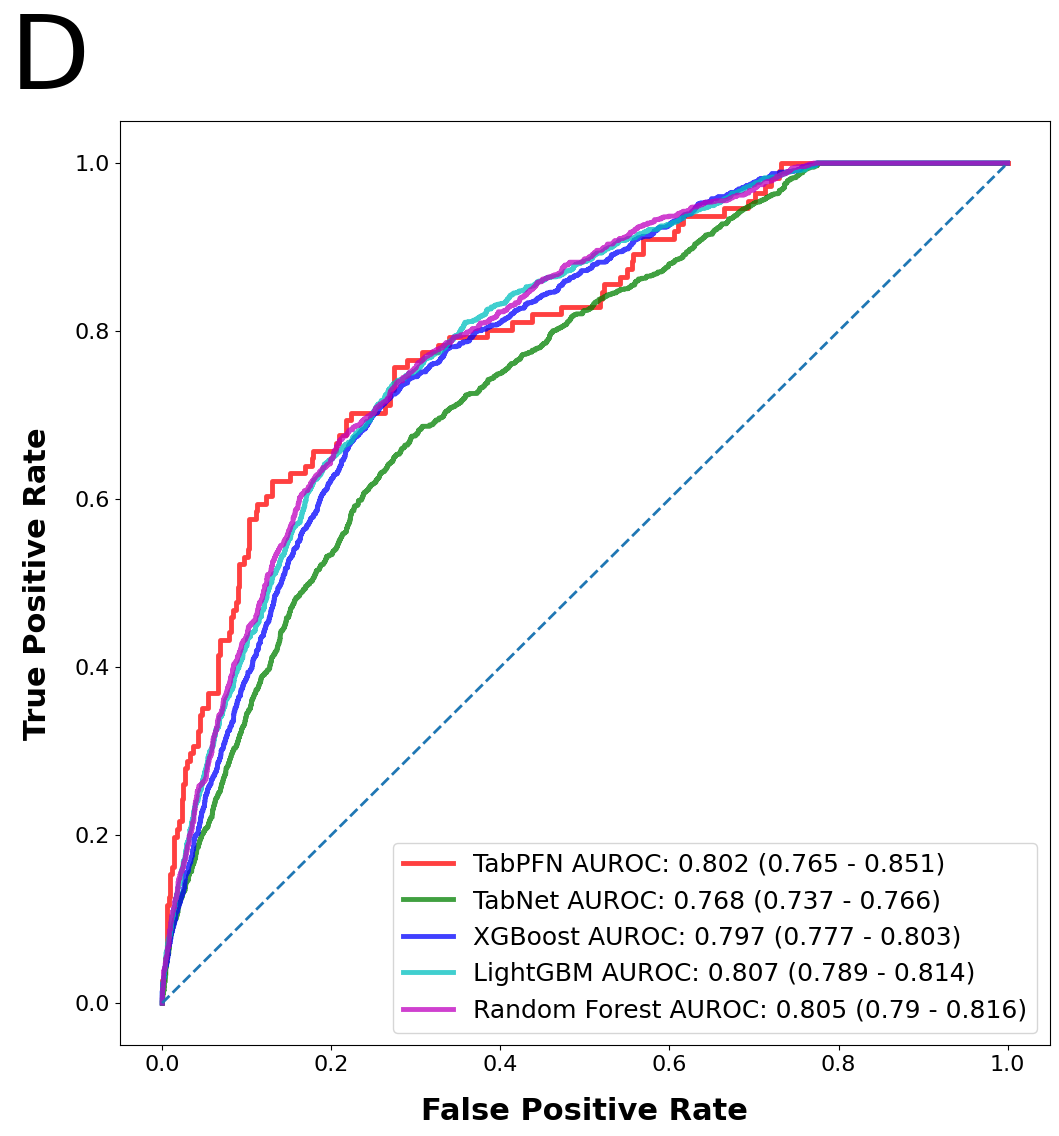

In [64]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_fpr, tabpfn_tpr, _ = roc_curve(tabpfn_y_test, probs_tabpfn)
tabpfn_label = 'TabPFN AUROC: ' + tabpfn_auroc_str
pyplot.plot(tabpfn_fpr, tabpfn_tpr, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)

tabnet_fpr, tabnet_tpr, _ = roc_curve(y_test, probs_tabnet)
tabnet_label = 'TabNet AUROC: ' + tabnet_auroc_str
pyplot.plot(tabnet_fpr, tabnet_tpr, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc_str
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc_str
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='c', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc_str
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('D', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_roc.png', dpi=300)
pyplot.show()

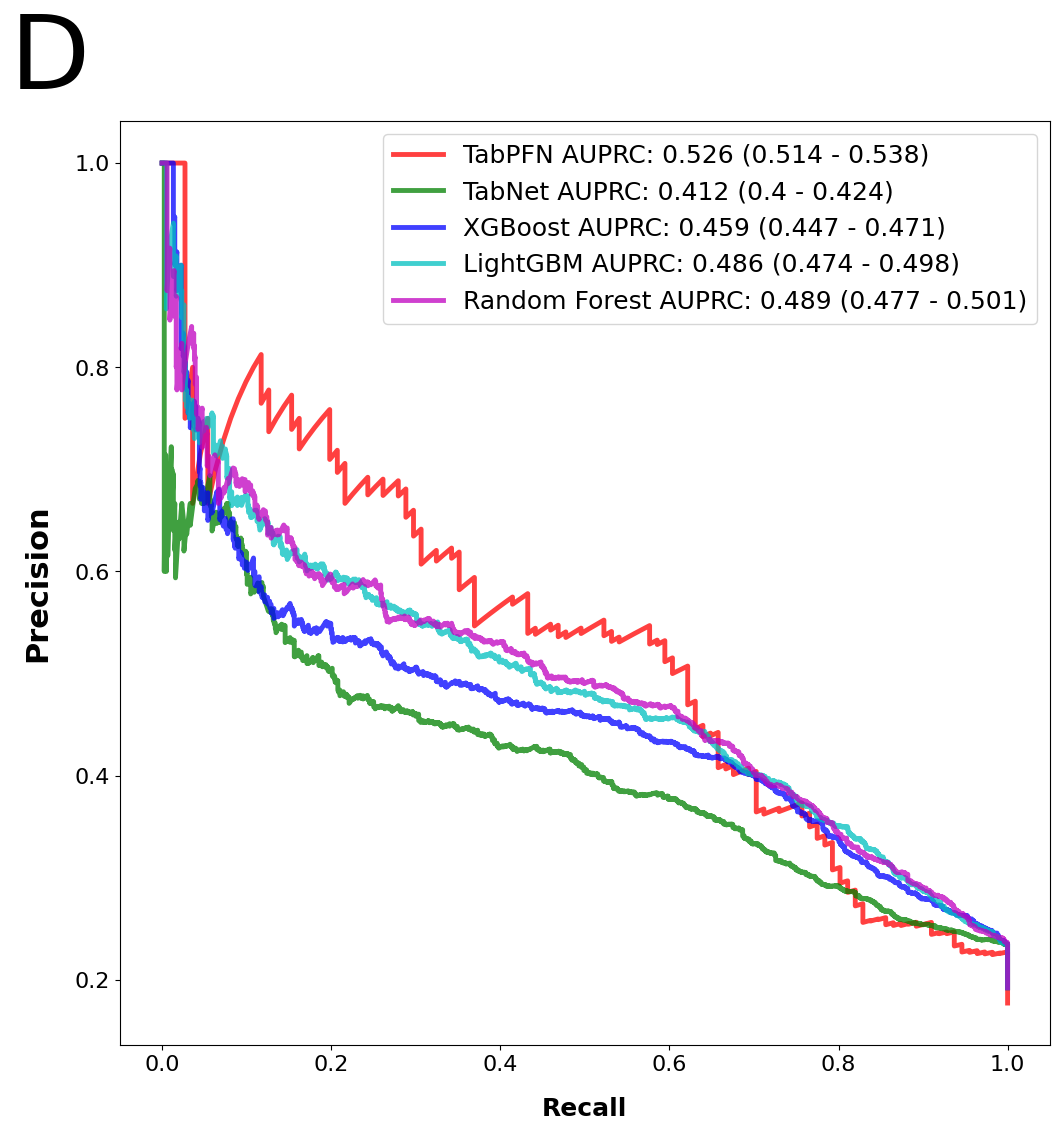

In [65]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_label = 'TabPFN AUPRC: ' + tabpfn_auprc_str
tabnet_label = 'TabNet AUPRC: ' + tabnet_auprc_str
xgb_label = 'XGBoost AUPRC: ' + xgb_auprc_str
lgb_label = 'LightGBM AUPRC: ' + lgb_auprc_str
rf_label = 'Random Forest AUPRC: ' + rf_auprc_str

pyplot.plot(tabpfn_recall_curve, tabpfn_precision_curve, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)
pyplot.plot(tabnet_recall_curve, tabnet_precision_curve, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)
pyplot.plot(xgb_recall_curve, xgb_precision_curve, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall_curve, lgb_precision_curve, label = lgb_label, color = 'c', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall_curve, rf_precision_curve, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.title('D', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 18, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [66]:
#Calculate means.

mean_precision = round((sum(list([tabpfn_precision, tabnet_precision, xgb_precision, lgb_precision, rf_precision]))/5), 3)
mean_precision_ci_lower = round((sum(list([tabpfn_precision_ci_lower, tabnet_precision_ci_lower, xgb_precision_ci_lower, lgb_precision_ci_lower, rf_precision_ci_lower]))/5), 3)
mean_precision_ci_upper = round((sum(list([tabpfn_precision_ci_upper, tabnet_precision_ci_upper, xgb_precision_ci_upper, lgb_precision_ci_upper, rf_precision_ci_upper]))/5), 3)
mean_precision_str = str(mean_precision) + ' (' + str(mean_precision_ci_lower) + ' - ' + str(mean_precision_ci_upper) + ')'

mean_recall = round((sum(list([tabpfn_recall, tabnet_recall, xgb_recall, lgb_recall, rf_recall]))/5), 3)
mean_recall_ci_lower = round((sum(list([tabpfn_recall_ci_lower, tabnet_recall_ci_lower, xgb_recall_ci_lower, lgb_recall_ci_lower, rf_recall_ci_lower]))/5), 3)
mean_recall_ci_upper = round((sum(list([tabpfn_recall_ci_upper, tabnet_recall_ci_upper, xgb_recall_ci_upper, lgb_recall_ci_upper, rf_recall_ci_upper]))/5), 3)
mean_recall_str = str(mean_recall) + ' (' + str(mean_recall_ci_lower) + ' - ' + str(mean_recall_ci_upper) + ')'

mean_auprc = round((sum(list([tabpfn_auprc, tabnet_auprc, xgb_auprc, lgb_auprc, rf_auprc]))/5), 3)
mean_auprc_ci_lower = round((sum(list([tabpfn_auprc_ci_lower, tabnet_auprc_ci_lower, xgb_auprc_ci_lower, lgb_auprc_ci_lower, rf_auprc_ci_lower]))/5), 3)
mean_auprc_ci_upper = round((sum(list([tabpfn_auprc_ci_upper, tabnet_auprc_ci_upper, xgb_auprc_ci_upper, lgb_auprc_ci_upper, rf_auprc_ci_upper]))/5), 3)
mean_auprc_str = str(mean_auprc) + ' (' + str(mean_auprc_ci_lower) + ' - ' + str(mean_auprc_ci_upper) + ')'

mean_accuracy = round((sum(list([tabpfn_accuracy, tabnet_accuracy, xgb_accuracy, lgb_accuracy, rf_accuracy]))/5), 3)
mean_accuracy_ci_lower = round((sum(list([tabpfn_accuracy_ci_lower, tabnet_accuracy_ci_lower, xgb_accuracy_ci_lower, lgb_accuracy_ci_lower, rf_accuracy_ci_lower]))/5), 3)
mean_accuracy_ci_upper = round((sum(list([tabpfn_accuracy_ci_upper, tabnet_accuracy_ci_upper, xgb_accuracy_ci_upper, lgb_accuracy_ci_upper, rf_accuracy_ci_upper]))/5), 3)
mean_accuracy_str = str(mean_accuracy) + ' (' + str(mean_accuracy_ci_lower) + ' - ' + str(mean_accuracy_ci_upper) + ')'

mean_auroc = round((sum(list([tabpfn_auroc, tabnet_auroc, xgb_auroc, lgb_auroc, rf_auroc]))/5), 3)
mean_auroc_ci_lower = round((sum(list([tabpfn_auroc_ci_lower, tabnet_auroc_ci_lower, xgb_auroc_ci_lower, lgb_auroc_ci_lower, rf_auroc_ci_lower]))/5), 3)
mean_auroc_ci_upper = round((sum(list([tabpfn_auroc_ci_upper, tabnet_auroc_ci_upper, xgb_auroc_ci_upper, lgb_auroc_ci_upper, rf_auroc_ci_upper]))/5), 3)
mean_auroc_str = str(mean_auroc) + ' (' + str(mean_auroc_ci_lower) + ' - ' + str(mean_auroc_ci_upper) + ')'

mean_brier = round((sum(list([tabpfn_brier, tabnet_brier, xgb_brier, lgb_brier, rf_brier]))/5), 3)
mean_brier_ci_lower = round((sum(list([tabpfn_brier_ci_lower, tabnet_brier_ci_lower, xgb_brier_ci_lower, lgb_brier_ci_lower, rf_brier_ci_lower]))/5), 3)
mean_brier_ci_upper = round((sum(list([tabpfn_brier_ci_upper, tabnet_brier_ci_upper, xgb_brier_ci_upper, lgb_brier_ci_upper, rf_brier_ci_upper]))/5), 3)
mean_brier_str = str(mean_brier) + ' (' + str(mean_brier_ci_lower) + ' - ' + str(mean_brier_ci_upper) + ')'

mean_results = [mean_precision_str, mean_recall_str, mean_auprc_str, mean_accuracy_str, mean_auroc_str, mean_brier_str]

In [67]:
results = {'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results}

results = pd.DataFrame(results, columns = ['TabPFN', 'TabNet', 'XGBoost', 'LightGBM', 'Random Forest', 'Mean'])

results

TabPFN                 TabNet                XGBoost  \
0   0.831 (0.822 - 0.84)  0.795 (0.785 - 0.805)  0.815 (0.805 - 0.825)   
1  0.722 (0.711 - 0.733)   0.699 (0.688 - 0.71)  0.726 (0.715 - 0.737)   
2  0.526 (0.514 - 0.538)    0.412 (0.4 - 0.424)  0.459 (0.447 - 0.471)   
3  0.736 (0.725 - 0.747)  0.688 (0.677 - 0.699)  0.725 (0.714 - 0.736)   
4  0.802 (0.765 - 0.851)  0.768 (0.737 - 0.766)  0.797 (0.777 - 0.803)   
5  0.115 (0.107 - 0.123)  0.137 (0.128 - 0.146)  0.129 (0.121 - 0.137)   

                LightGBM          Random Forest                   Mean  
0  0.817 (0.807 - 0.827)  0.816 (0.806 - 0.826)  0.815 (0.805 - 0.825)  
1  0.732 (0.721 - 0.743)   0.739 (0.728 - 0.75)  0.724 (0.713 - 0.735)  
2  0.486 (0.474 - 0.498)  0.489 (0.477 - 0.501)  0.474 (0.462 - 0.486)  
3   0.729 (0.718 - 0.74)  0.727 (0.716 - 0.738)   0.721 (0.71 - 0.732)  
4  0.807 (0.789 - 0.814)   0.805 (0.79 - 0.816)   0.796 (0.772 - 0.81)  
5  0.126 (0.118 - 0.134)  0.125 (0.117 - 0.133)  0.126 (0.118 - 0.135)

In [68]:
results = pd.DataFrame({'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results})

results = results.T

results.columns = ['Weighted Precision (95% CI)', 'Weighted Recall (95% CI)',  'Weighted AUPRC (95% CI)', 'Balanced Accuracy (95% CI)', 'AUROC (95% CI)', 'Brier Score']

results.to_csv('/content/drive/MyDrive/TQP-atSDH/iculos_results.csv')

results

Weighted Precision (95% CI) Weighted Recall (95% CI)  \
TabPFN               0.831 (0.822 - 0.84)    0.722 (0.711 - 0.733)   
TabNet              0.795 (0.785 - 0.805)     0.699 (0.688 - 0.71)   
XGBoost             0.815 (0.805 - 0.825)    0.726 (0.715 - 0.737)   
LightGBM            0.817 (0.807 - 0.827)    0.732 (0.721 - 0.743)   
Random Forest       0.816 (0.806 - 0.826)     0.739 (0.728 - 0.75)   
Mean                0.815 (0.805 - 0.825)    0.724 (0.713 - 0.735)   

              Weighted AUPRC (95% CI) Balanced Accuracy (95% CI)  \
TabPFN          0.526 (0.514 - 0.538)      0.736 (0.725 - 0.747)   
TabNet            0.412 (0.4 - 0.424)      0.688 (0.677 - 0.699)   
XGBoost         0.459 (0.447 - 0.471)      0.725 (0.714 - 0.736)   
LightGBM        0.486 (0.474 - 0.498)       0.729 (0.718 - 0.74)   
Random Forest   0.489 (0.477 - 0.501)      0.727 (0.716 - 0.738)   
Mean            0.474 (0.462 - 0.486)       0.721 (0.71 - 0.732)   

                      AUROC (95% CI)            Brier Score  
TabPFN         0.802 (0.765 - 0.851)  0.115 (0.107 - 0.123)  
TabNet         0.768 (0.737 - 0.766)  0.137 (0.128 - 0.146)  
XGBoost        0.797 (0.777 - 0.803)  0.129 (0.121 - 0.137)  
LightGBM       0.807 (0.789 - 0.814)  0.126 (0.118 - 0.134)  
Random Forest   0.805 (0.79 - 0.816)  0.125 (0.117 - 0.133)  
Mean            0.796 (0.772 - 0.81)  0.126 (0.118 - 0.135)

# SHAP Plots

In [69]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [70]:
x_test = x_test[x_test['Age'] > 18]
x_test = x_test[x_test['Age'] < 90]

x_test = x_test[x_test['Weight'] > 30]
x_test = x_test[x_test['Weight'] < 250]

x_test = x_test[x_test['Height'] > 100]
x_test = x_test[x_test['Height'] < 220]

x_test = x_test[x_test['Systolic Blood Pressure'] > 50]
x_test = x_test[x_test['Systolic Blood Pressure'] < 250]

x_test = x_test[x_test['Pulse Rate'] > 20]
x_test = x_test[x_test['Pulse Rate'] < 220]

x_test = x_test[x_test['Respiratory Rate'] > 4]
x_test = x_test[x_test['Respiratory Rate'] < 50]

x_test = x_test[x_test['Days from Incident to ED or Hospital Arrival'] > 0]
x_test = x_test[x_test['Days from Incident to ED or Hospital Arrival'] < 14]

In [71]:
x_test_sample = x_test.sample(frac=0.05, random_state=42)
tabpfn_x_test_sample = tabpfn_x_test.sample(frac=0.05, random_state=42)
tabnet_x_test_sample = x_test.sample(frac=0.05, random_state = 31)

feature_names = x_test_sample.columns

In [72]:
#Calculate SHAP values for TabPFN.

tabpfn_explainer = shap.Explainer(tabpfn.predict, tabpfn_x_test_sample)
tabpfn_shap_values = tabpfn_explainer(tabpfn_x_test_sample)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


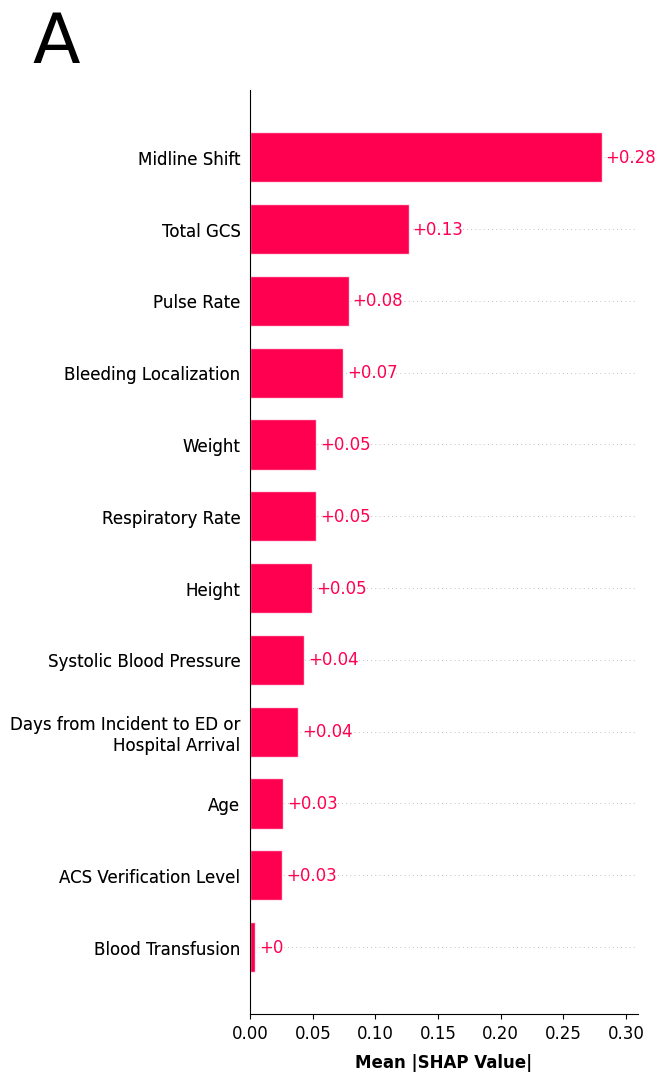

In [73]:
#Plot SHAP bar plot for TabPFN.

shap.plots.bar(tabpfn_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_shap_tabpfn.png', dpi=300, bbox_inches='tight')

In [74]:
#Calculate SHAP values for TabNet.

tabnet_explainer = shap.Explainer(tabnet.predict, x_test_sample.values, feature_names=feature_names)
tabnet_shap_values = tabnet_explainer(x_test_sample.values)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


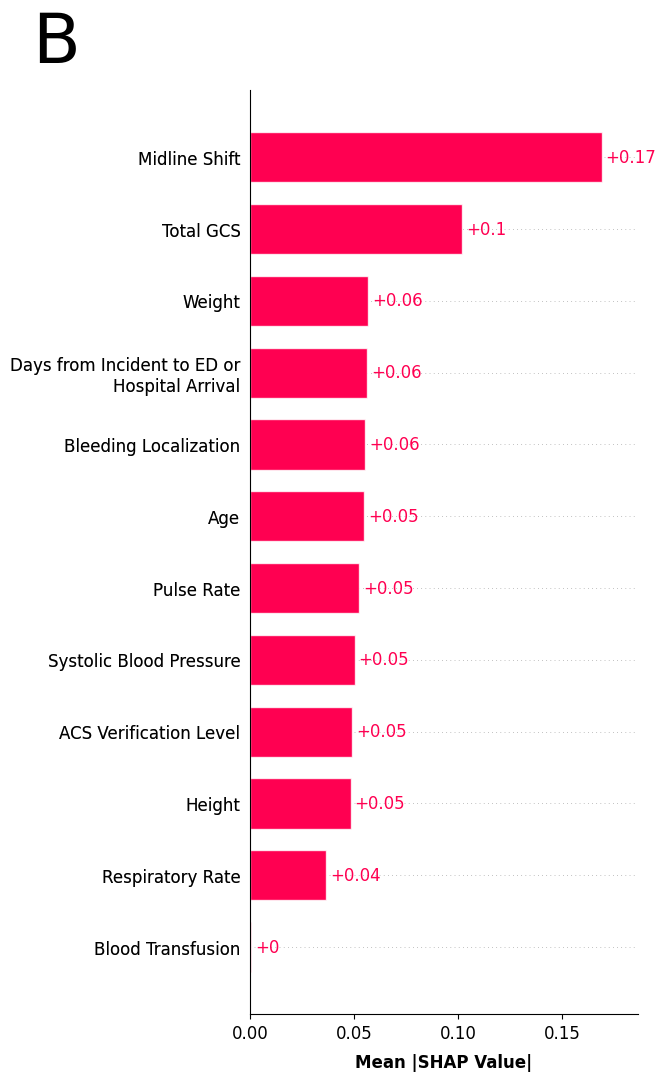

In [75]:
#Plot SHAP bar plot for TabNet.

shap.plots.bar(tabnet_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_shap_tabnet.png', dpi=300, bbox_inches='tight')

In [76]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test_sample)
xgb_shap_values = xgb_explainer(x_test_sample)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


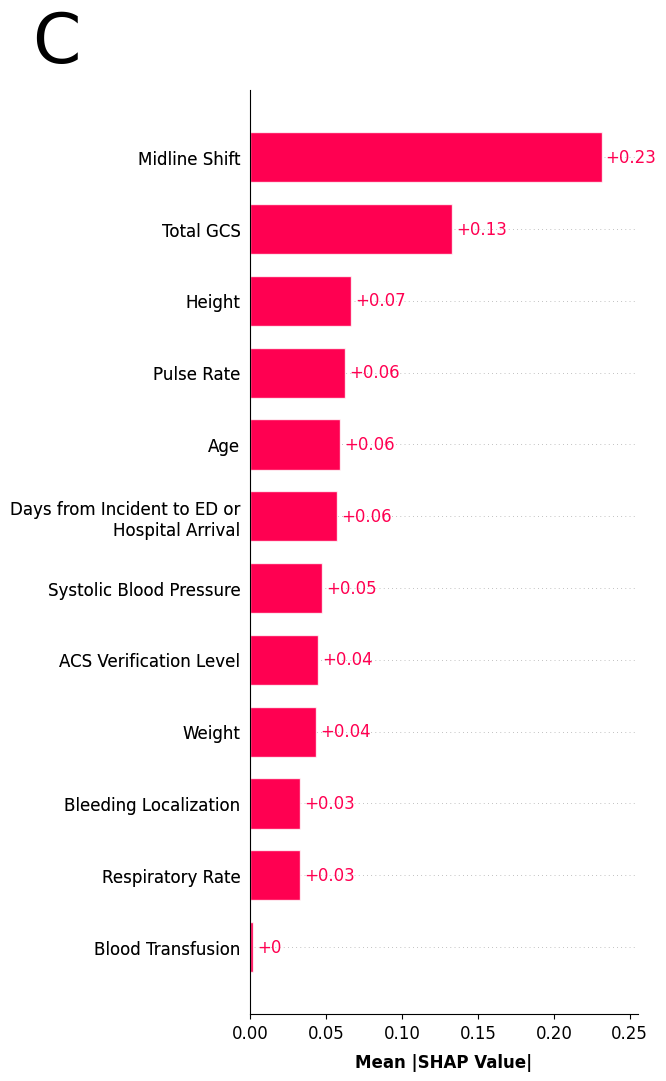

In [77]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_shap_xgb.png', dpi=300, bbox_inches='tight')

In [ ]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test_sample)
lgb_shap_values = lgb_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.b

In [ ]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_shap_lgb.png', dpi=300, bbox_inches='tight')

In [80]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test_sample)
rf_shap_values = rf_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


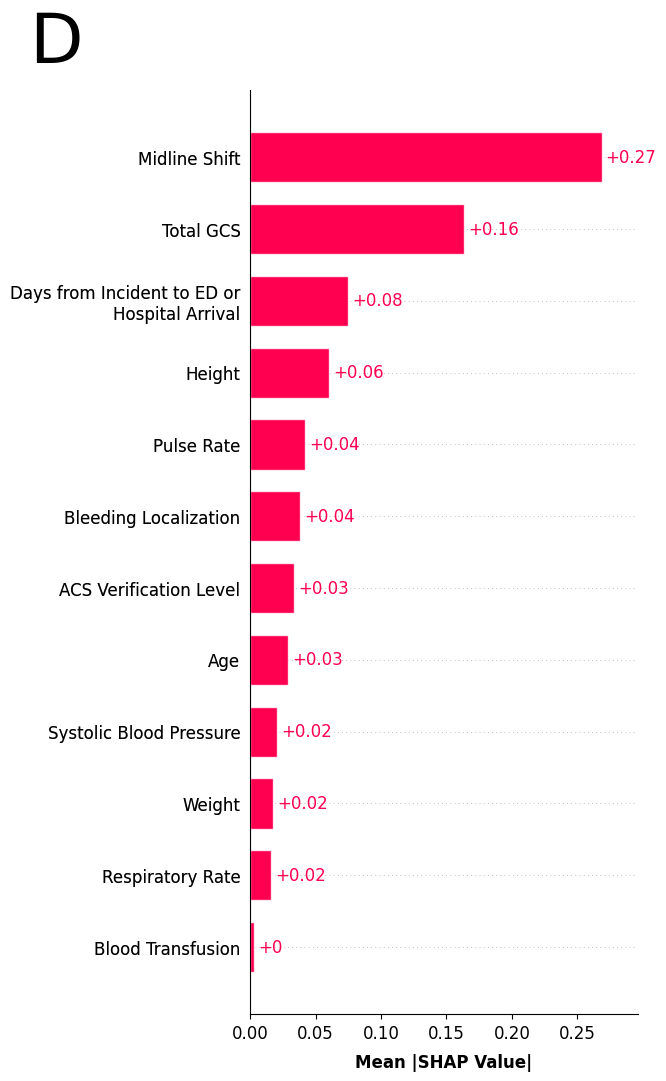

In [81]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_shap_rf.png', dpi=300, bbox_inches='tight')

#Partial Dependency Plots

In [82]:
pyplot.rcParams["figure.figsize"] = (15, 20)
pyplot.rcParams["figure.dpi"] = 300
pyplot.rcParams['axes.labelweight'] = 'bold'
pyplot.rcParams['axes.labelsize'] = 12
pyplot.rcParams['axes.labelpad'] = 6
pyplot.rcParams['font.weight'] = 'normal'
pyplot.rcParams['lines.linewidth'] = 2.5
pyplot.rcParams['xtick.labelsize'] = 8
pyplot.rcParams['ytick.labelsize'] = 8

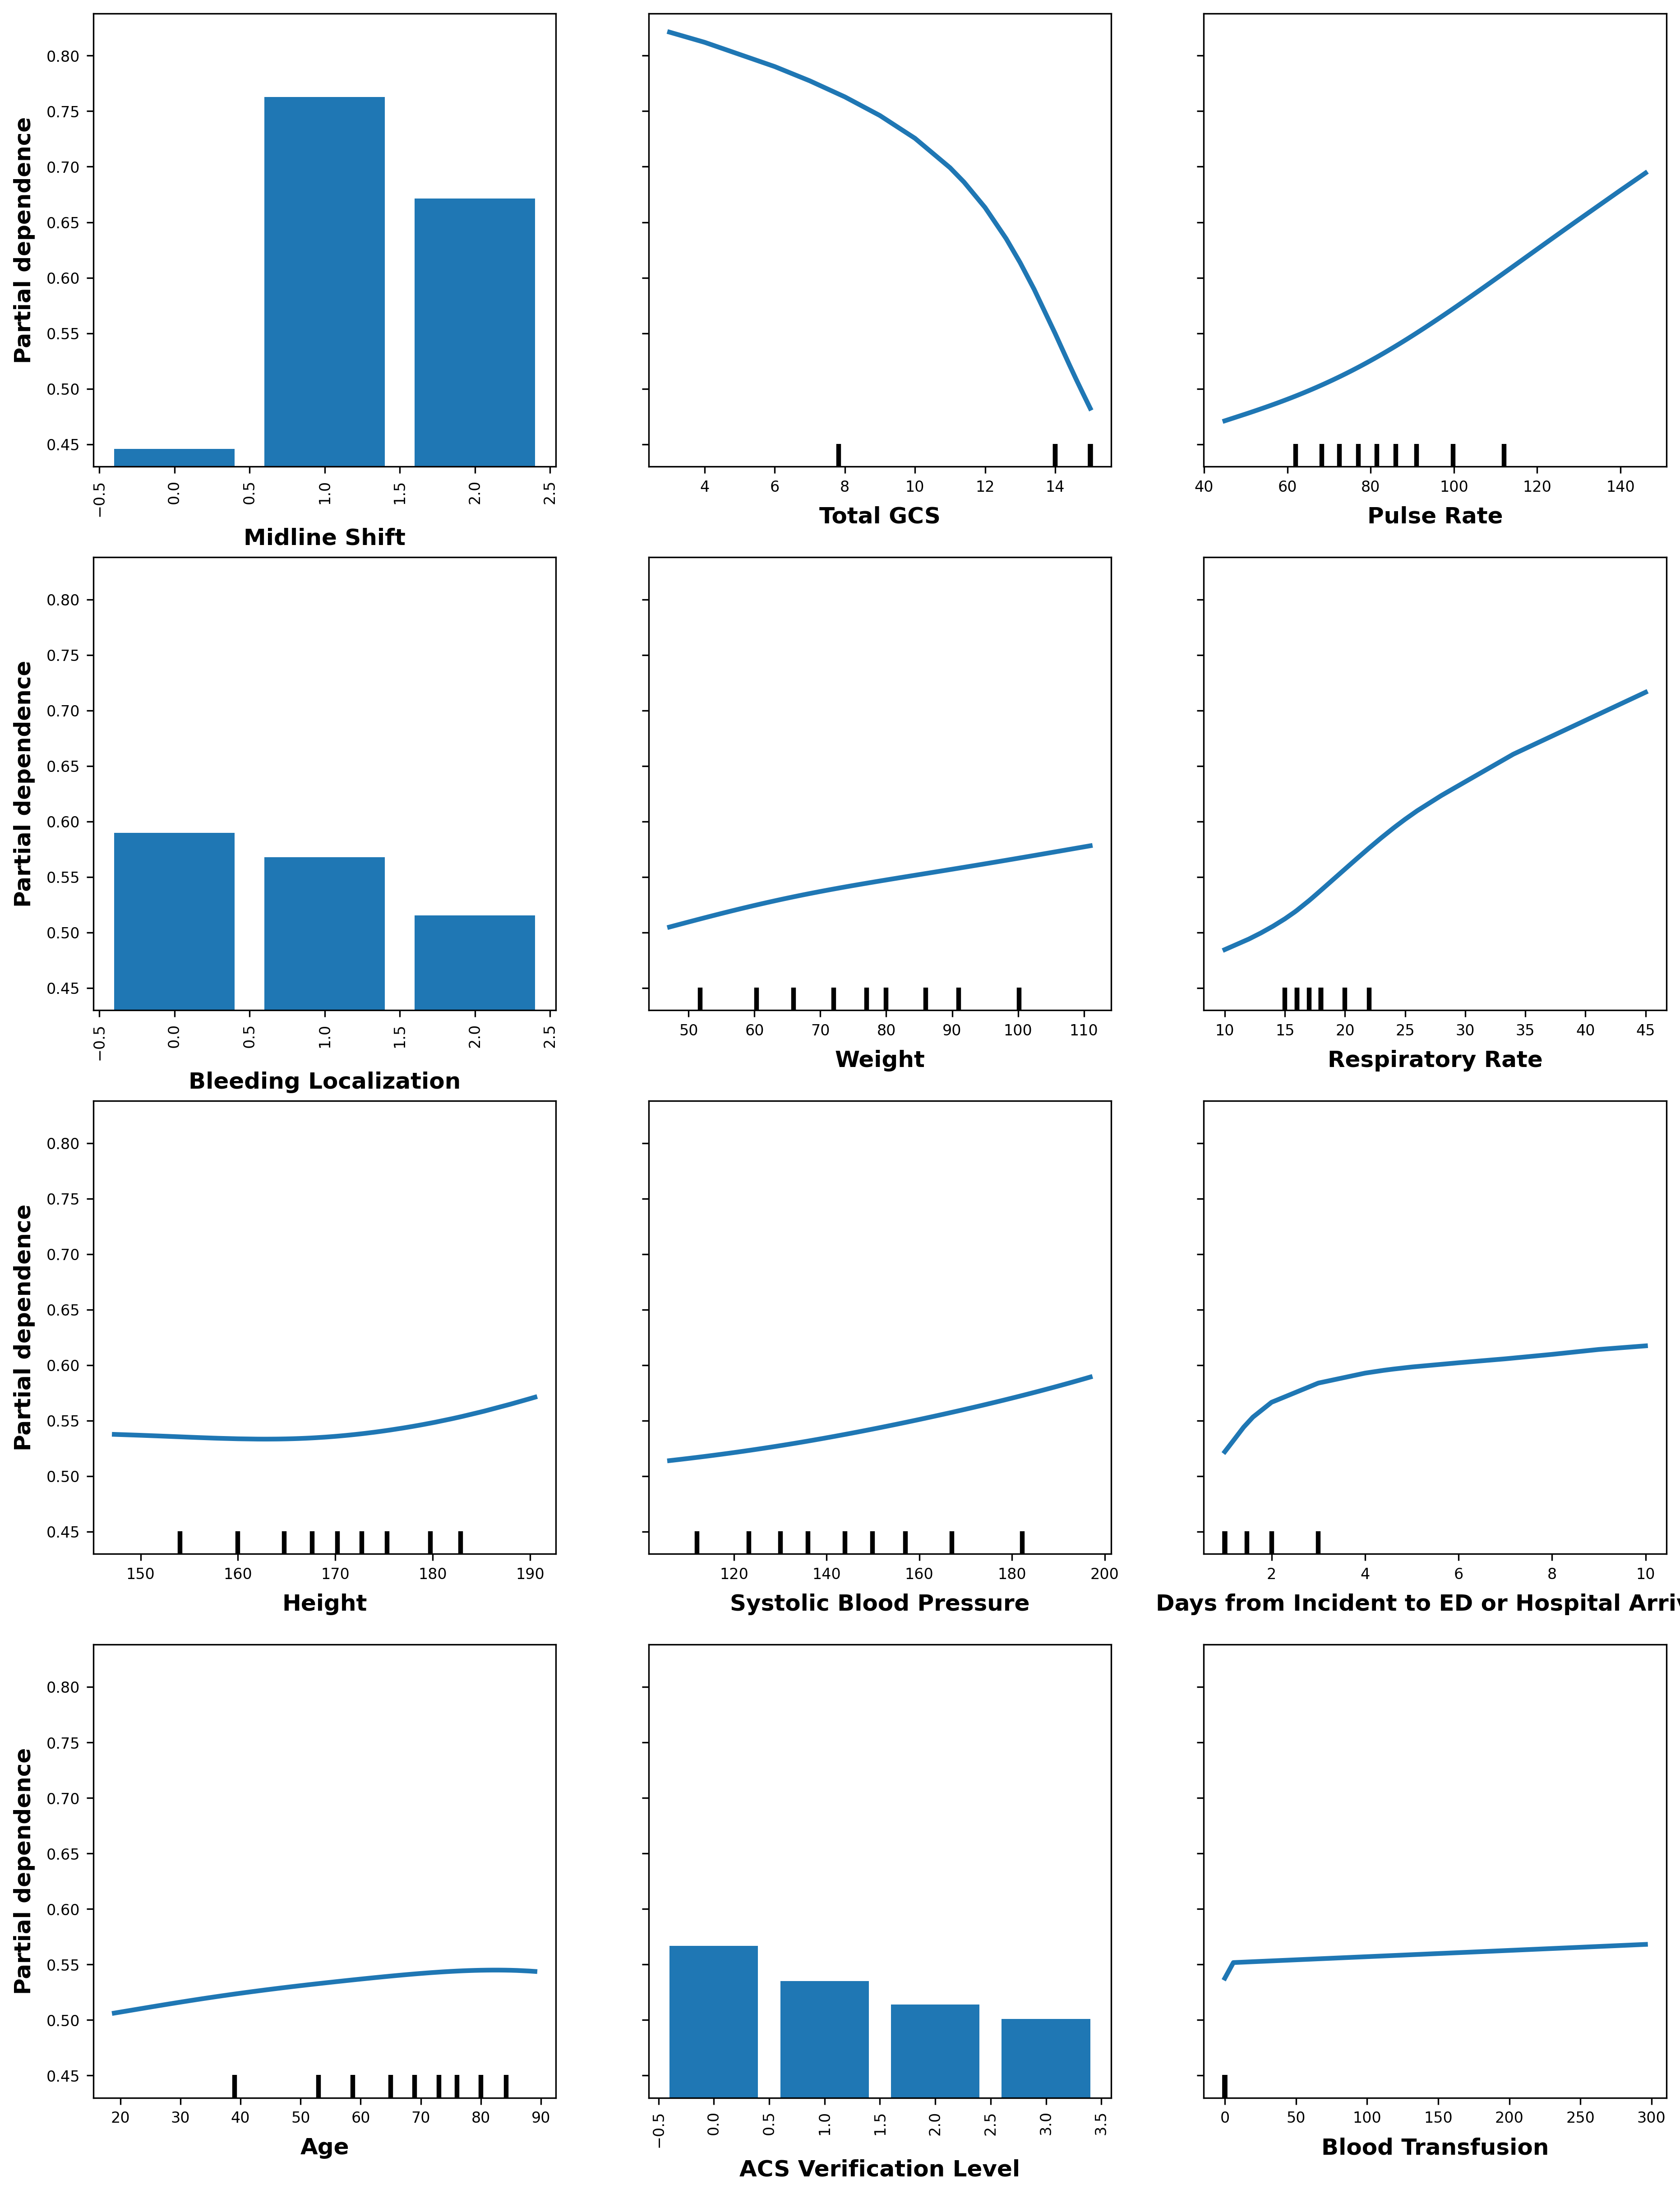

In [83]:
#Calculate the mean absolute SHAP values for each feature.
tabpfn_mean_abs_shap_values = np.mean(np.abs(tabpfn_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabpfn_shap_summary = pd.DataFrame(list(zip(feature_names, tabpfn_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabpfn_shap_summary_sorted = tabpfn_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabpfn_features = tabpfn_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(tabpfn, x_test_sample, tabpfn_features, categorical_features = ['Midline Shift', 'Bleeding Localization', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_pdp_tabpfn.png', dpi=300, bbox_inches='tight')
pyplot.show()

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
tabnet_mean_abs_shap_values = np.mean(np.abs(tabnet_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabnet_shap_summary = pd.DataFrame(list(zip(feature_names, tabnet_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabnet_shap_summary_sorted = tabnet_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabnet_features = tabnet_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, tabnet_x_test_sample, tabnet_features, categorical_features = ['Midline Shift', 'Bleeding Localization', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_pdp_tabnet.png', dpi=300, bbox_inches='tight')
pyplot.show()

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
xgb_mean_abs_shap_values = np.mean(np.abs(xgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
xgb_shap_summary = pd.DataFrame(list(zip(feature_names, xgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
xgb_shap_summary_sorted = xgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
xgb_features = xgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, x_test_sample, xgb_features, categorical_features = ['Midline Shift', 'Bleeding Localization', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_pdp_xgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

In [ ]:
#Calculate the mean absolute SHAP values for each feature.
lgb_mean_abs_shap_values = np.mean(np.abs(lgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
lgb_shap_summary = pd.DataFrame(list(zip(feature_names, lgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
lgb_shap_summary_sorted = lgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
lgb_features = lgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(lgb, x_test_sample, lgb_features, categorical_features = ['Midline Shift', 'Bleeding Localization', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_pdp_lgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


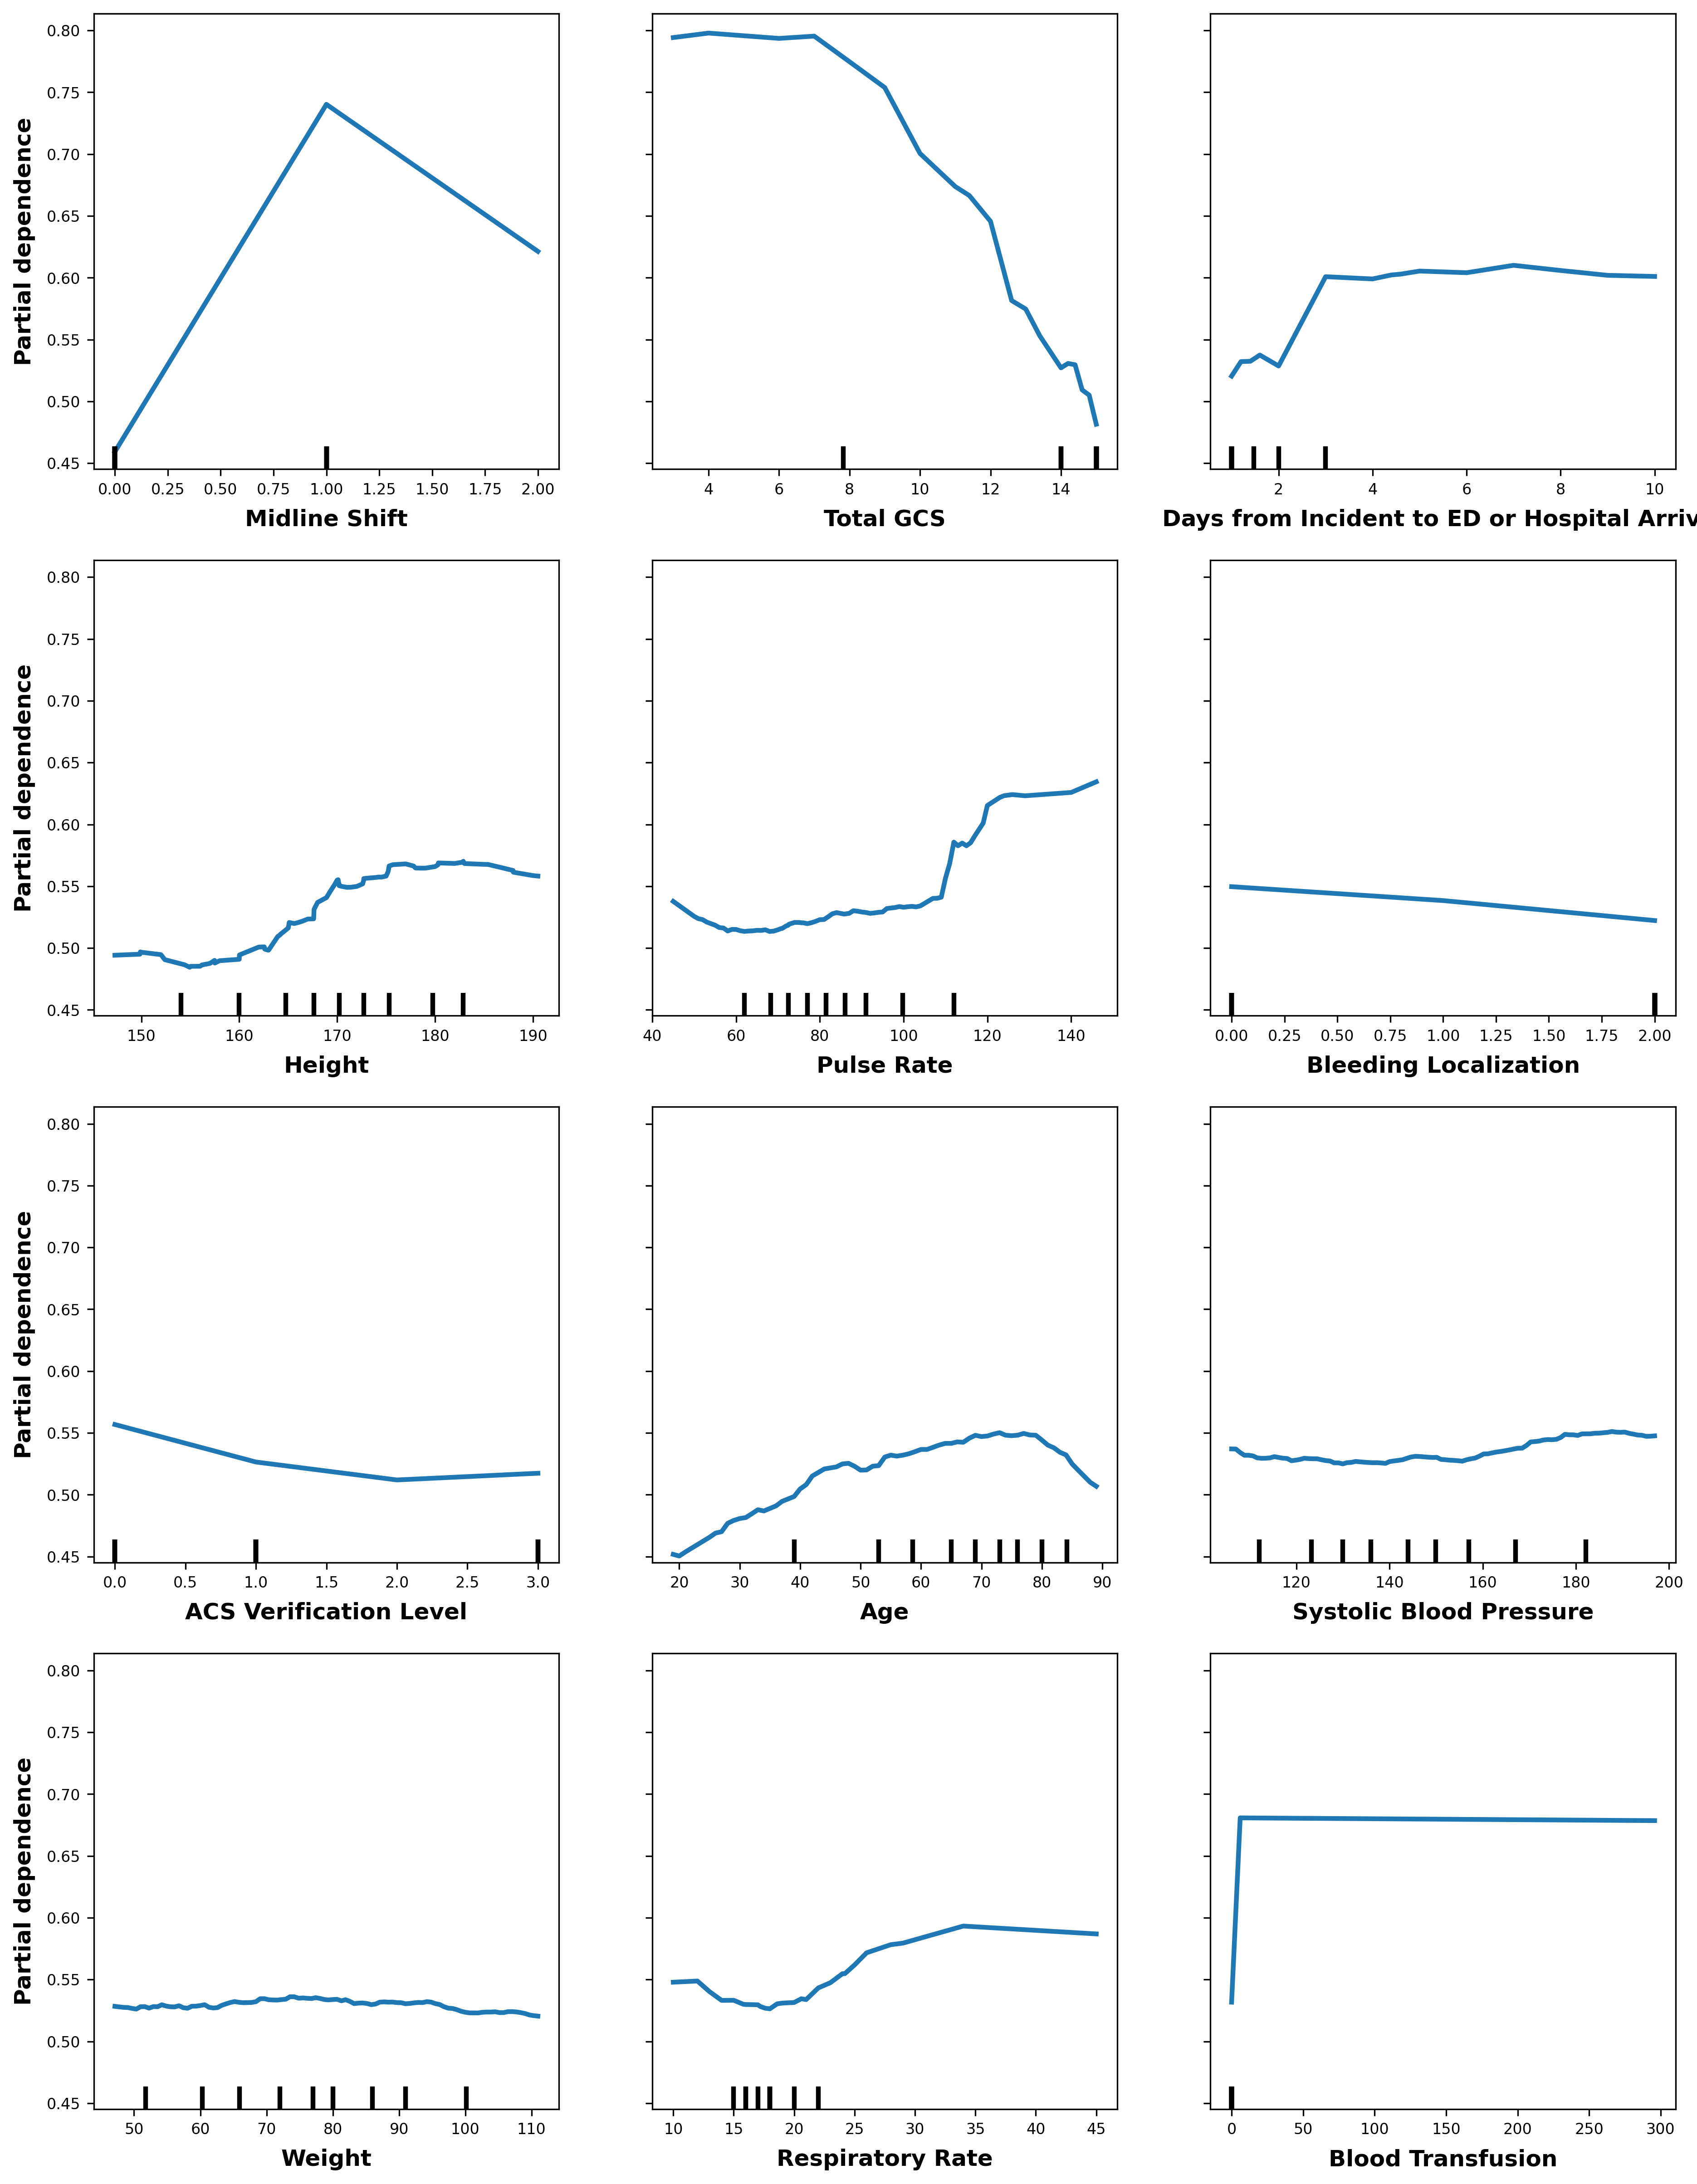

In [87]:
#Calculate the mean absolute SHAP values for each feature.
rf_mean_abs_shap_values = np.mean(np.abs(rf_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
rf_shap_summary = pd.DataFrame(list(zip(feature_names, rf_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
rf_shap_summary_sorted = rf_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
rf_features = rf_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(rf, x_test_sample, rf_features)
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/iculos_pdp_rf.png', dpi=300, bbox_inches='tight')
pyplot.show()